In [15]:
import os
import cv2
import keras
import numpy as np
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.16.1


In [16]:
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi

[]
Sat May 18 17:22:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  NVIDIA T1000 8GB               Off | 00000000:01:00.0 Off |                  N/A |
| 37%   36C    P8              N/A /  50W |      8MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0   N/A  N/A    136610      G   /usr/lib/xorg/Xorg                            4MiB |
+---------

In [17]:
# Input image size that we are going to use
IMAGE_SIZE = 128
num_classes = 4
# Set batch size
batch = 32
# Set learning rate
LR = 1e-4
# Set epoch
EPOCHS = 60

In [18]:
# Set image and mask paths
image_path = "IE-dataset-All-tts-augmented/IE-dataset-All-tts-augmented/images/"
mask_path = "IE-dataset-All-tts-augmented/IE-dataset-All-tts-augmented/masks/"
training_data = "train/"
val_data = "validation/"
test_data = "test/"

In [19]:
# Function to create lists of paths for training, validation and testing data
def load_data():
  extensions = ["*.jpg", "*.tif", "*.tiff"]
  file_patterns = [os.path.join(image_path, training_data, ext) for ext in extensions]

  TRAIN_X = sorted(sum((glob(pattern) for pattern in file_patterns), []))
  # TRAIN_X = sorted(glob(os.path.join(image_path + training_data, "*.jpg")))
  train_x = TRAIN_X

  TRAIN_Y = sorted(glob(os.path.join(mask_path + training_data, "*.png")))
  train_y = TRAIN_Y

  file_patterns = [os.path.join(image_path, val_data, ext) for ext in extensions]
  VALID_TEST_X = sorted(sum((glob(pattern) for pattern in file_patterns), []))
  # VALID_TEST_X = sorted(glob(os.path.join(image_path + val_data, "*.jpg")))
  valid_x = VALID_TEST_X

  VALID_TEST_Y = sorted(glob(os.path.join(mask_path + val_data, "*.png")))
  valid_y = VALID_TEST_Y

  file_patterns = [os.path.join(image_path, test_data, ext) for ext in extensions]
  TEST_X = sorted(sum((glob(pattern) for pattern in file_patterns), []))
  test_x = TEST_X
  TEST_Y = sorted(glob(os.path.join(mask_path + test_data, "*.png")))
  test_y = TEST_Y

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [20]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Test data: ", len(test_x))

Training data:  308
Validation data:  16
Test data:  15


In [21]:
# Set image augmentation (to be called by tensorflow dataset later)
data_augmentation = tf.keras.Sequential([
  # layers.RandomFlip("horizontal_and_vertical"),
  # layers.RandomRotation(0.2),
  # layers.RandomZoom(.5, .2),
  # layers.RandomContrast(0.1)
  ],
  )

In [22]:
# Functions to read image and mask paths to output numpy arrays
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    return x

In [23]:
# Function to generate tensorflow dataset 
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.uint8])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

num_threads = 4

def tf_dataset_train(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    # newdataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(1)
    return dataset
    


def tf_dataset_valid(x, y, batch=batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.repeat()
    dataset = dataset.map(tf_parse, num_parallel_calls=num_threads)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(1)
    return dataset

In [24]:
train_dataset = tf_dataset_train(train_x, train_y)
valid_dataset = tf_dataset_valid(valid_x, valid_y)
test_dataset = tf_dataset_valid(test_x, test_y)

In [25]:
# Function to load image/mask and convert colour space from BGR to RGB so that image/mask can be displayed correctly by matplotlib
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [26]:
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [27]:
# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=4):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [28]:
model = unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=4)

/tmp/ipykernel_2516838/1288640795.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = MobileNetV2(input_tensor=inputs, include_top=False)


In [29]:
# Specify all the encoder layers in a list
encoder_layers = model.layers[0:-22]

In [30]:
# Freeze the encoder layers for transfer learning (so that weights are only Augmentedchanged for the decoder layers druing training)
for layer in encoder_layers:
    layer.trainable = False
    # print(layer, layer.trainable)

In [31]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,611,556 (17.59 MB)

 Trainable params: 3,993,828 (15.24 MB)

 Non-trainable params: 617,728 (2.36 MB)

In [ ]:
# Plot the unet model
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
# Functions for dice coefficient and dice loss 

import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    true_sum = K.sum(y_true_f , axis=-1)
    pred_sum = K.sum(y_pred_f, axis=-1)
    return K.mean((2. * intersect / (true_sum+pred_sum + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def mean_iou(y_true, y_pred, num_classes=4):
  smooth = 1e-7  
  y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)[..., 1:])
  y_pred_f = K.flatten(y_pred[..., 1:])
  intersection = K.sum(K.cast(y_true_f * y_pred_f, dtype='float32'), axis=-1)
  set_sum = K.sum(K.cast(y_true_f + y_pred_f, dtype='float32'), axis=-1)
  iou = (intersection + smooth) / (set_sum -intersection+ smooth)
  mIoU = K.mean(iou)
  return mIoU

def mIoU_loss(y_true, y_pred):
    return 1 - mean_iou(y_true, y_pred)
   


In [34]:
# Set up loss function, optimiser and complile the model 
opt = tf.keras.optimizers.AdamW(LR)
metrics = [dice_coef,mean_iou]
model.compile(loss=mIoU_loss, optimizer=opt, metrics=metrics)
#model.compile(optimizer=opt, loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [35]:
# Set up early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=4, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.3,   
    patience=4, 
    min_lr=0.001,
)


In [36]:
# Set up checkpoint for saving model architecture and weights
checkpoint_filepath = 'checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [37]:
# Commencement of training
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0: 
    train_steps += 1
if len(valid_x) % batch != 0: 
    valid_steps += 1

history=model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint_callback,early_stopping,reduce_lr]
)


Epoch 1/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - dice_coef: 0.3322 - loss: 0.7978 - mean_iou: 0.2022 - val_dice_coef: 0.3985 - val_loss: 0.7512 - val_mean_iou: 0.2488 - learning_rate: 1.0000e-04
Epoch 2/60


/home/sukrit/.local/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/home/sukrit/.local/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: dice_coef,loss,mean_iou,val_dice_coef,val_loss,val_mean_iou
  current = self.get_monitor_value(logs)
/home/sukrit/.local/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:97: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: dice_coef,loss,mean_iou,val_dice_coef,val_loss,val_mean_iou,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - dice_coef: 0.5878 - loss: 0.5829 - mean_iou: 0.4171 - val_dice_coef: 0.4700 - val_loss: 0.6928 - val_mean_iou: 0.3072 - learning_rate: 1.0000e-04
Epoch 3/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - dice_coef: 0.6656 - loss: 0.5008 - mean_iou: 0.4992 - val_dice_coef: 0.4778 - val_loss: 0.6861 - val_mean_iou: 0.3139 - learning_rate: 1.0000e-04
Epoch 4/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - dice_coef: 0.7317 - loss: 0.4224 - mean_iou: 0.5776 - val_dice_coef: 0.5039 - val_loss: 0.6632 - val_mean_iou: 0.3368 - learning_rate: 1.0000e-04
Epoch 5/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - dice_coef: 0.7387 - loss: 0.4135 - mean_iou: 0.5865 - val_dice_coef: 0.5377 - val_loss: 0.6323 - val_mean_iou: 0.3677 - learning_rate: 1.0000e-04
Epoch 6/60
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - dice_coef: 0.7438 - loss: 0.4069 - mean_iou: 0.5931 - val_dice_coef: 0.5433 - val_loss: 0.6270 - val_mean_iou: 0.3730 - learning_rate: 1.0000e-04
Epoch 7/60
10/10 ━━━━

In [38]:
def display_sample(sample_image,sample_mask_seperated,pred_mask_seperated):
    # plt.figure(figsize=(16, 16))
    title = ['bg','fat','cell','bone']
    # for i in range(len(display_list)):
    #     plt.subplot(1, len(display_list), i+1)
    #     plt.title(title[i])
    #     plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    #     plt.axis('off')
    # plt.show()

    fig,axs=plt.subplots(2,5,figsize=(30,12))
    axs[0][0].imshow(sample_image)
    axs[0][0].axis('off')
    axs[0][0].set_title('Original Image')
    for i in range(4):
        axs[0][i+1].imshow(sample_mask_seperated[i],cmap='gray')
        axs[0][i+1].axis('off')
        axs[0][i+1].set_title(f'Original {title[i]}')
    for i in range(4):
        axs[1][i+1].imshow(pred_mask_seperated[i],cmap='gray')
        axs[1][i+1].axis('off')
        axs[1][i+1].set_title(f'Predicted {title[i]}')
    plt.show()

In [39]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1) 
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions(sample_image,sample_mask):
    one_img = sample_image[0][tf.newaxis, ...] 
    prediction = model.predict(one_img)
    pred_mask = create_mask(prediction)

    sample_mask_seperated=[(sample_mask[0]==i) for i in [0,1,2,3]]
    pred_mask_seperated=[(pred_mask[0]==i) for i in [0,1,2,3]]

    display_sample(sample_image[0], sample_mask_seperated,pred_mask_seperated)#sample_mask_seperated, pred_mask_seperated)
    
    fat_true=np.sum(sample_mask_seperated[1])
    cell_true=np.sum(sample_mask_seperated[2])
    fat_pred=np.sum(pred_mask_seperated[1])
    cell_pred=np.sum(pred_mask_seperated[2])
    cellularity_true=(cell_true*100)/(cell_true+fat_true)
    cellularity_pred=(cell_pred*100)/(cell_pred+fat_pred)
    cellularity_accuracy=(1-abs(cellularity_pred-cellularity_true)/100)*100
    print(f"cellulu true={cellularity_true:.3f}%\tcellulu pred='{cellularity_pred:.3f}%\tDifference={cellularity_accuracy:.3f}%")
    return cellularity_accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


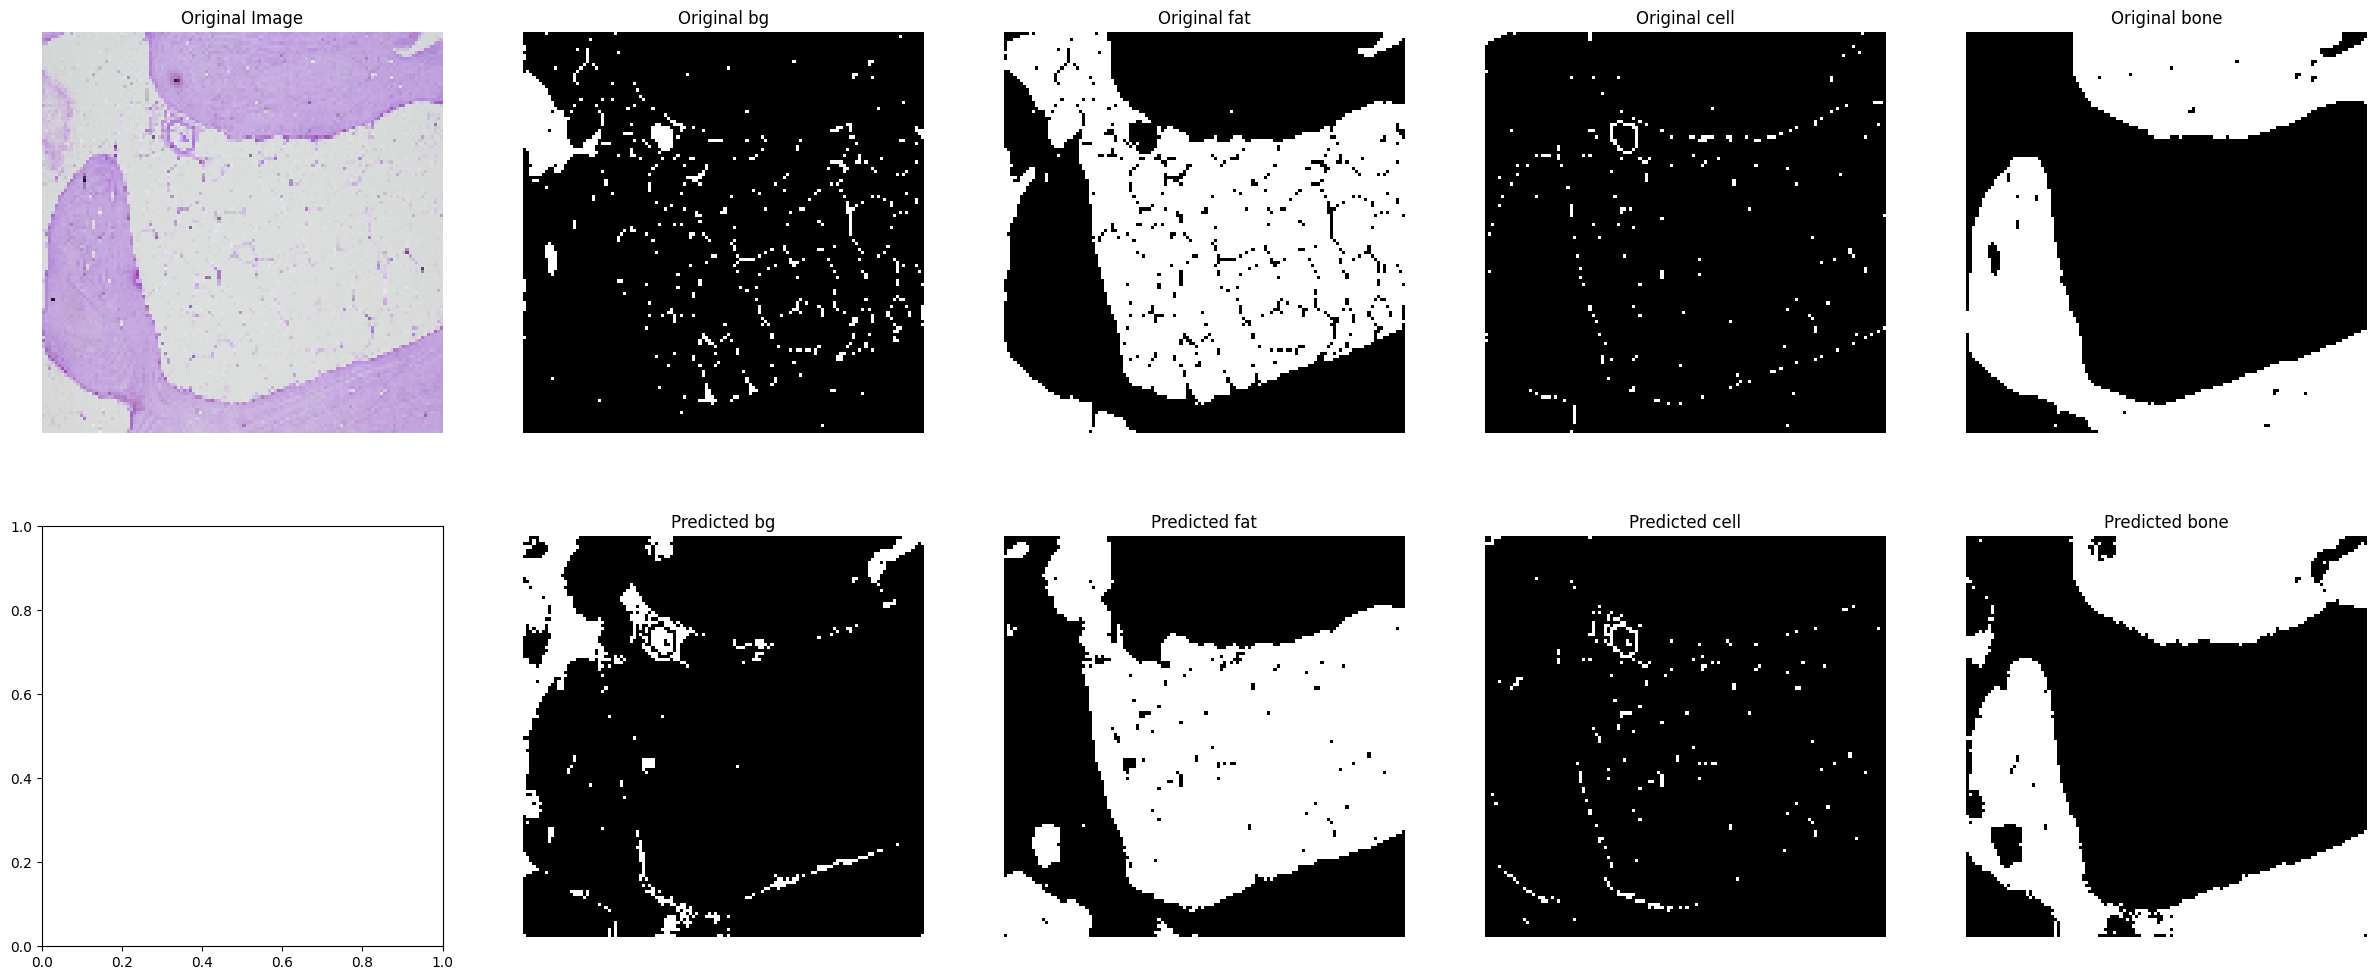

cellulu true=2.797%	cellulu pred='2.890%	Difference=99.907%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


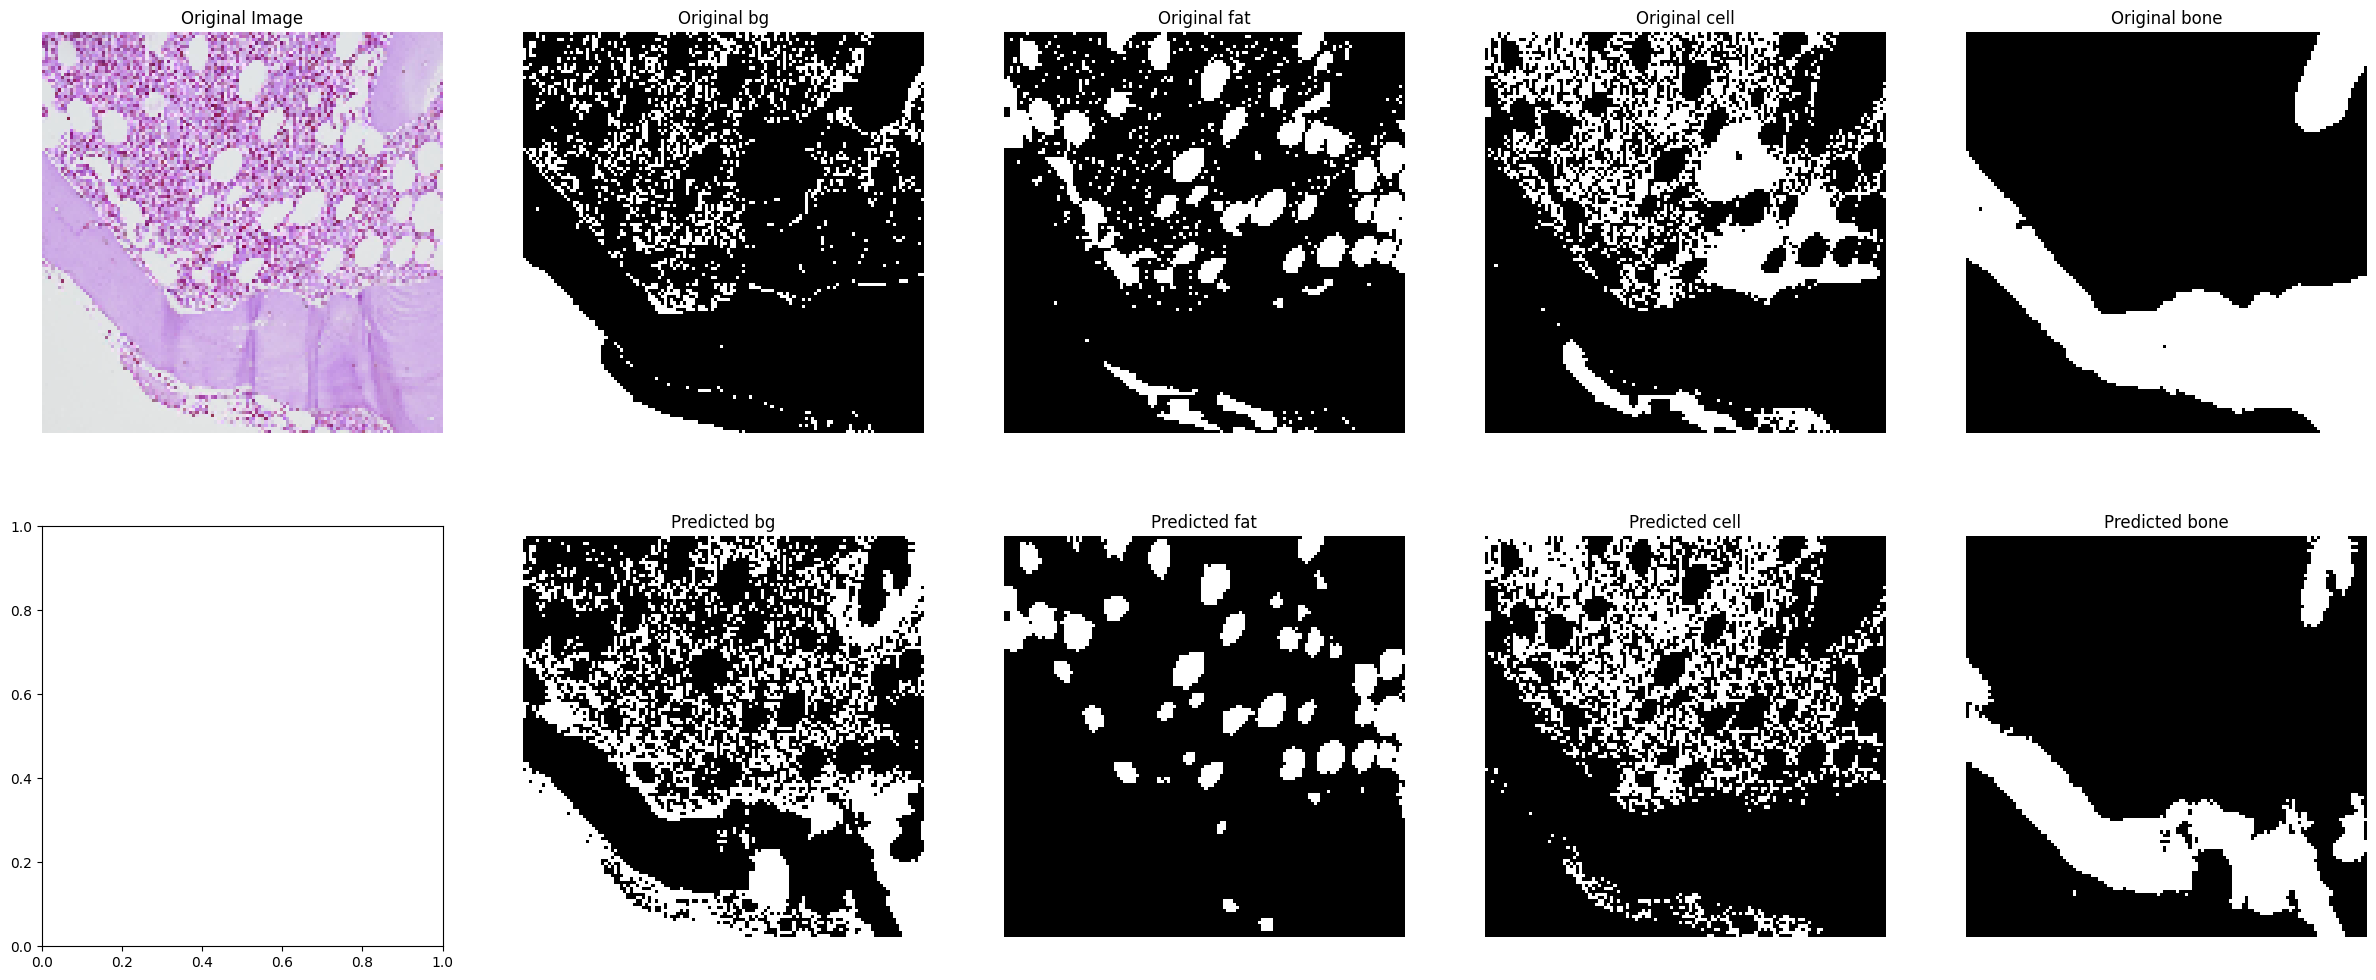

cellulu true=62.076%	cellulu pred='68.685%	Difference=93.391%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


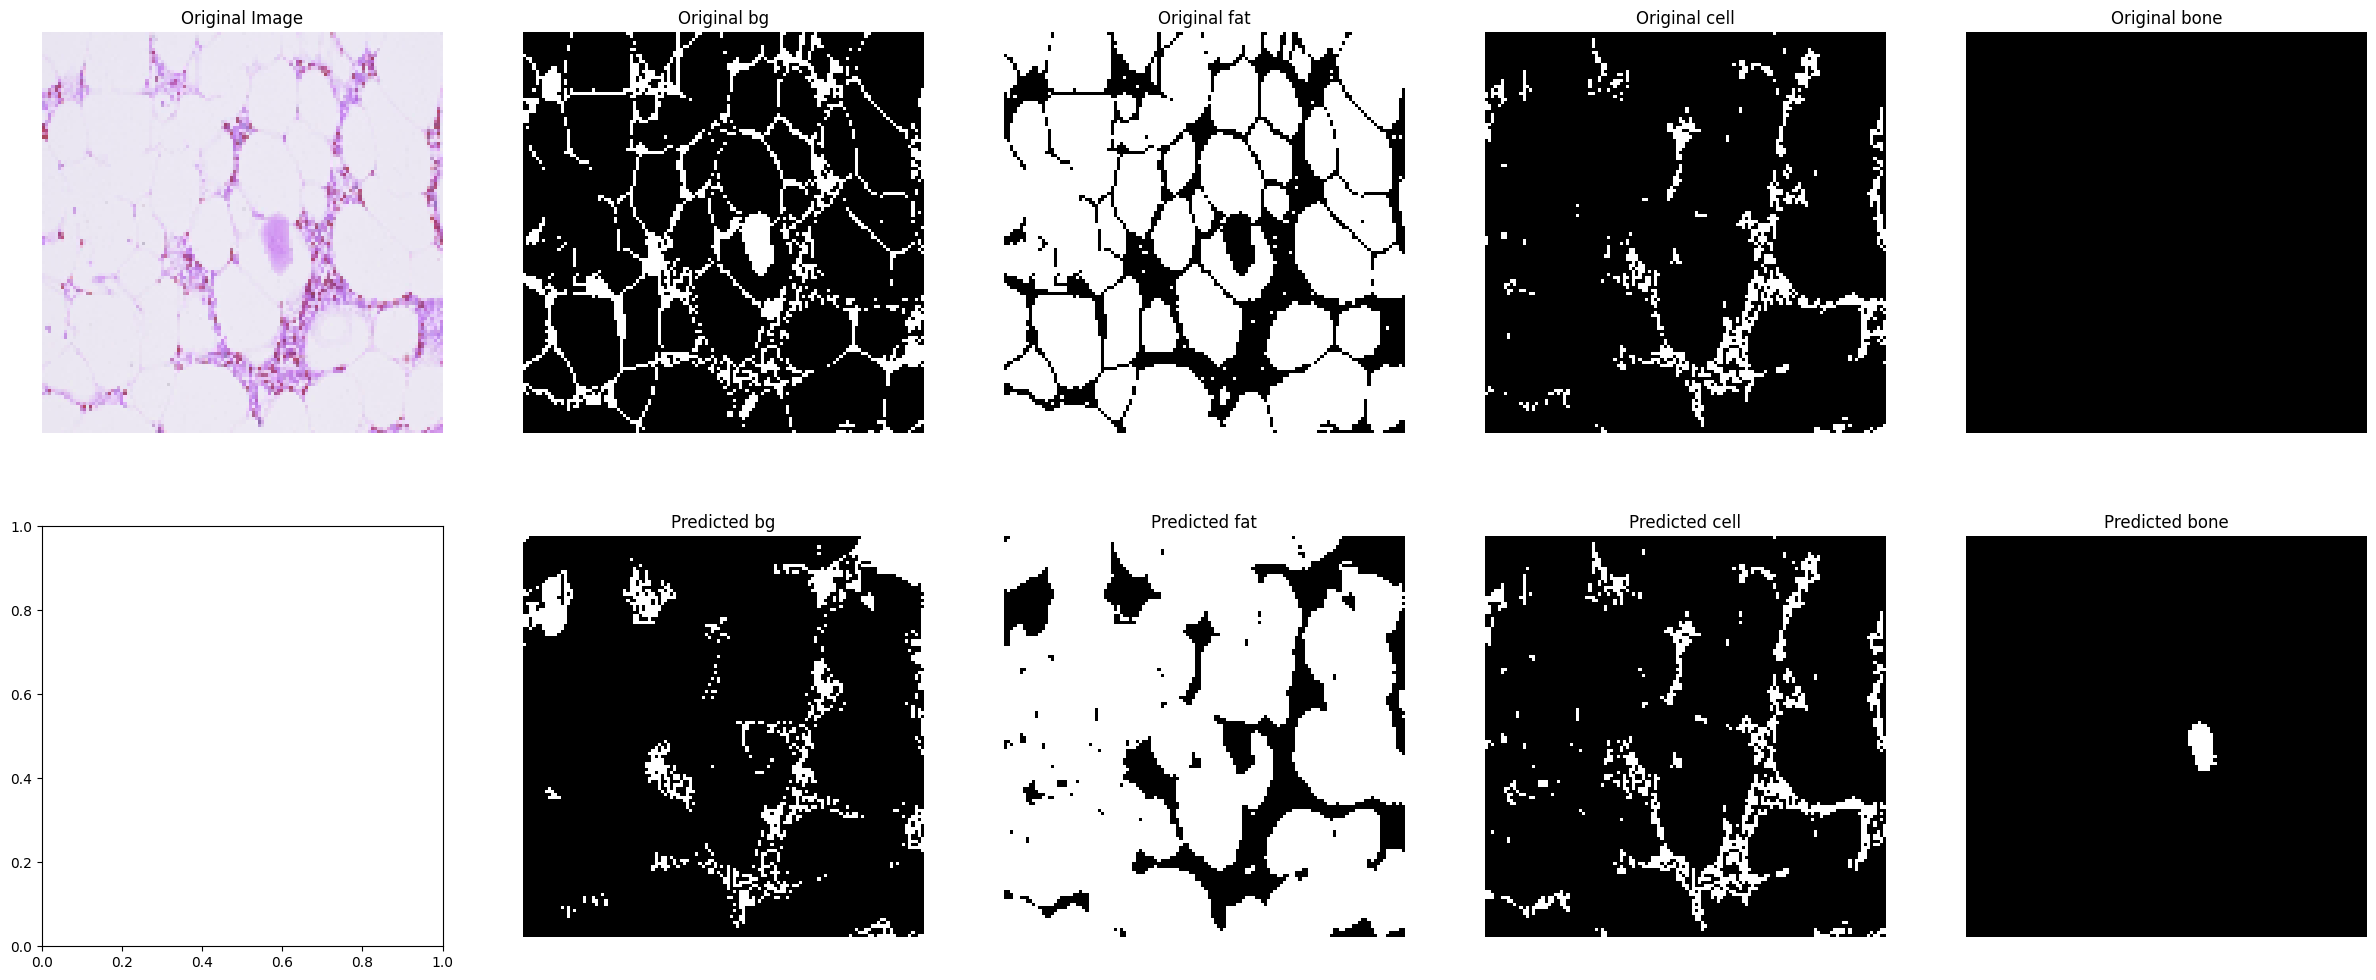

cellulu true=9.536%	cellulu pred='10.438%	Difference=99.098%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


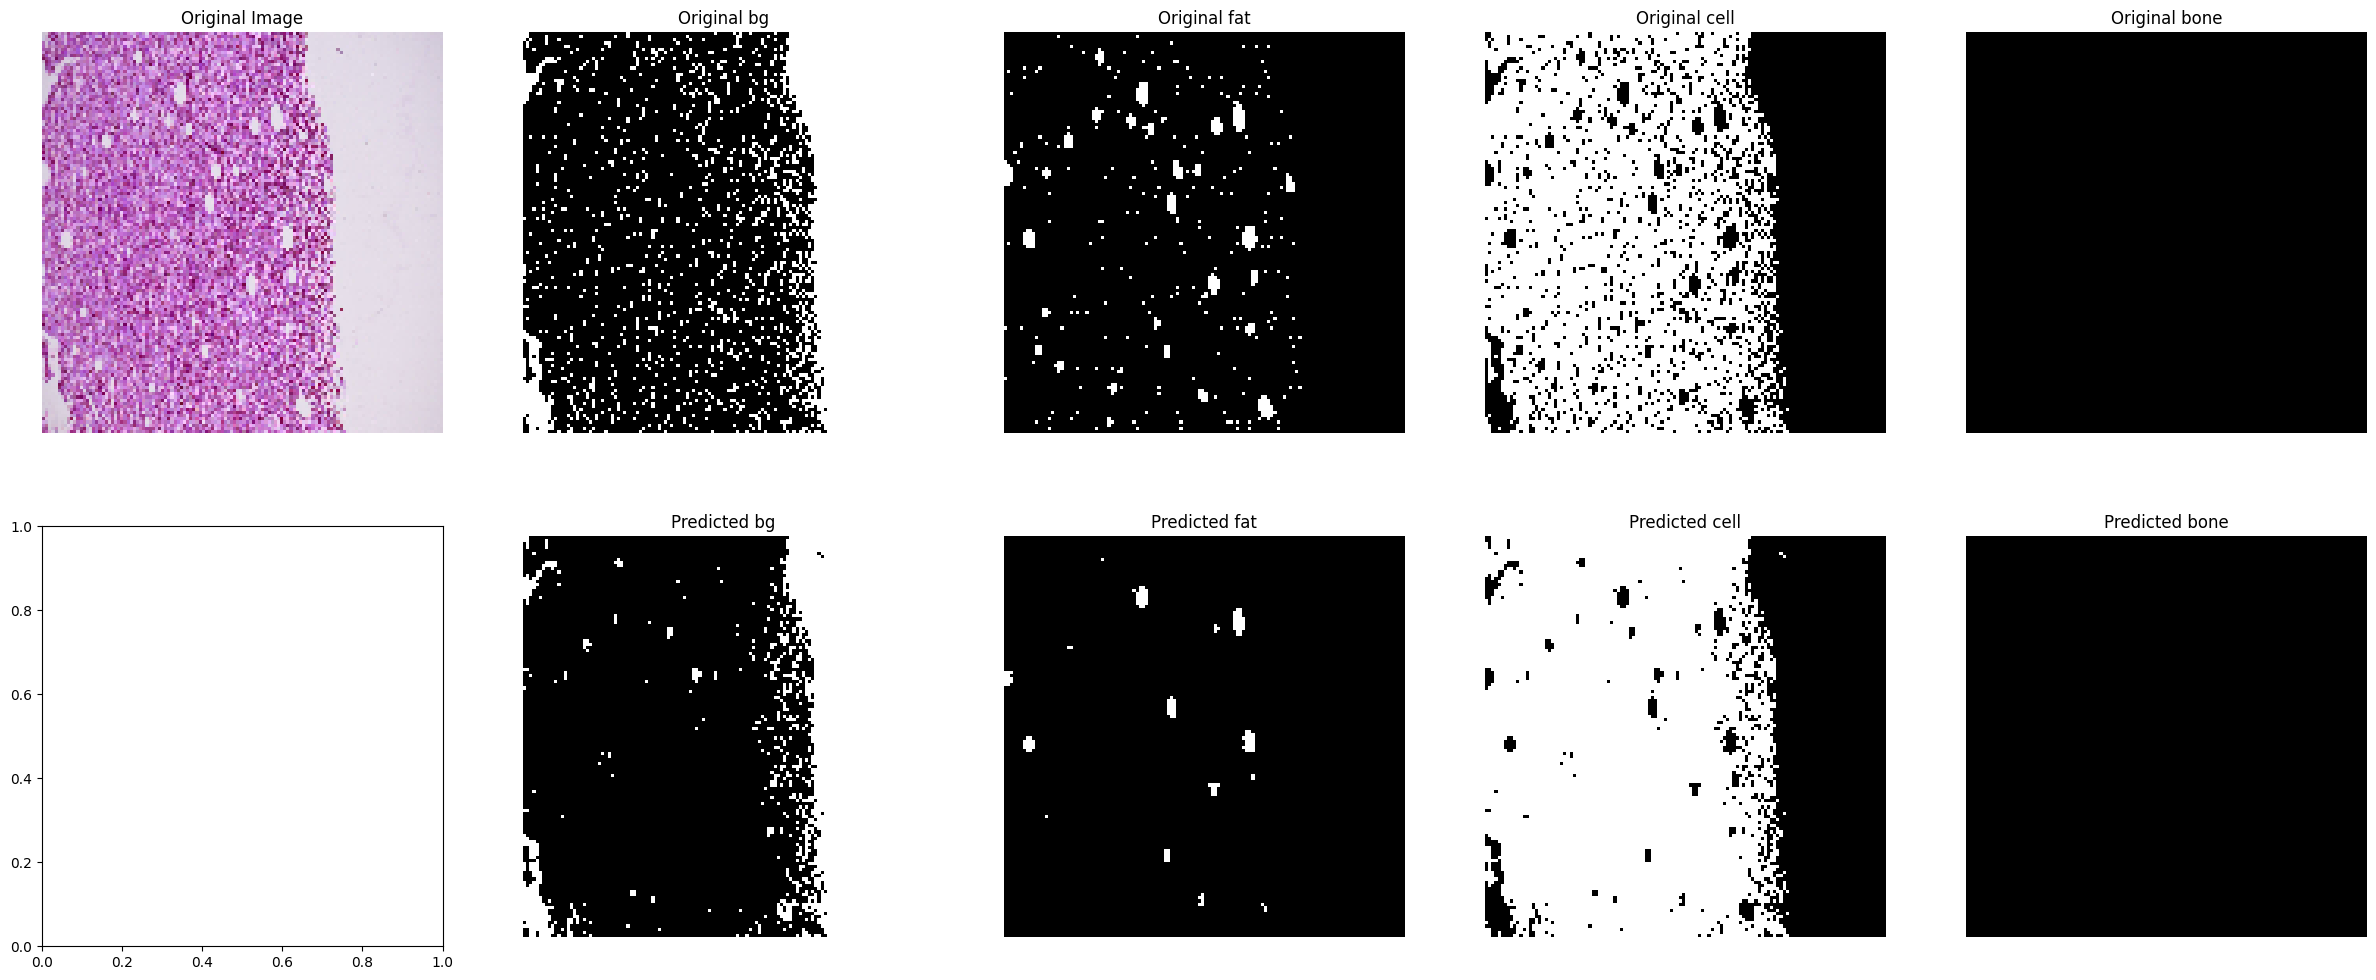

cellulu true=94.033%	cellulu pred='98.561%	Difference=95.472%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


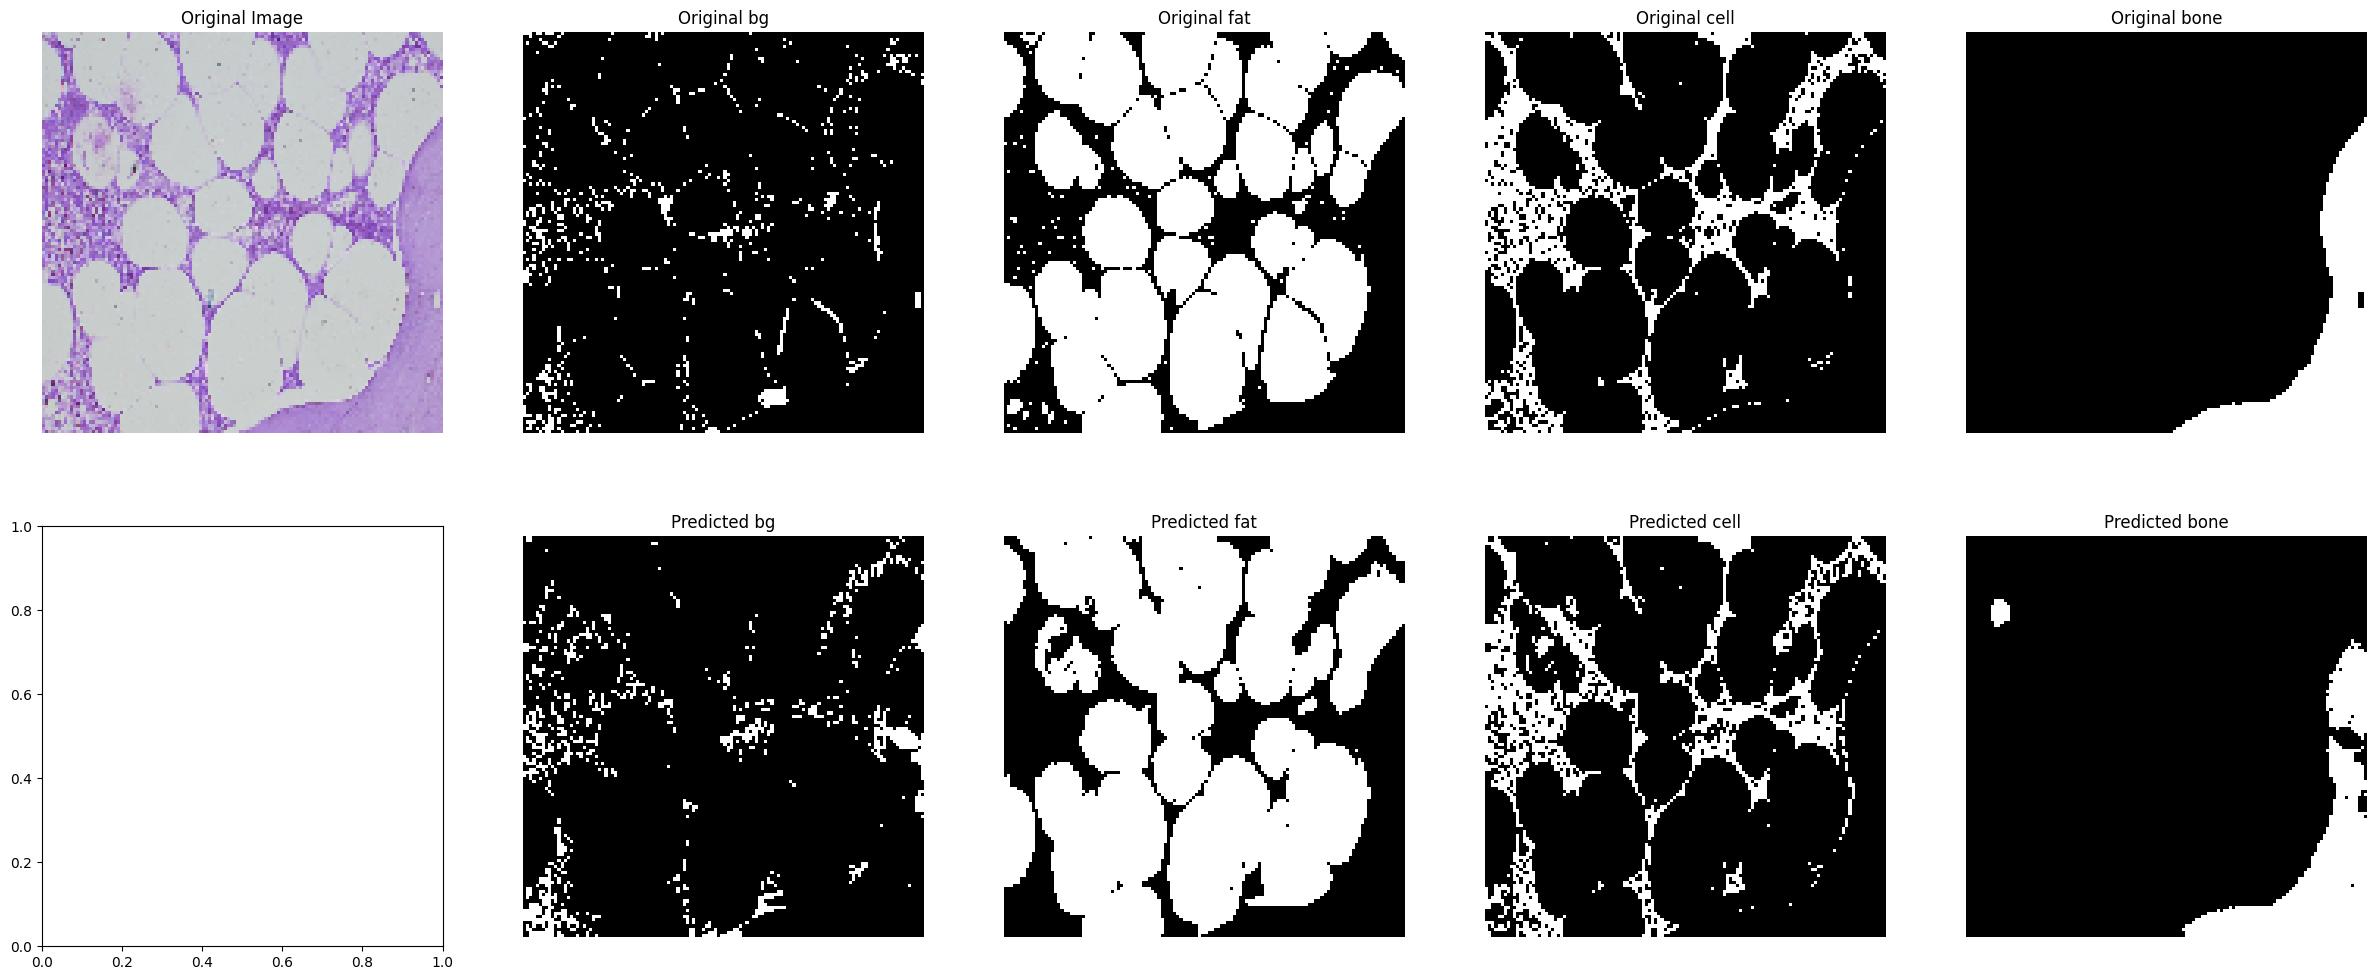

cellulu true=23.318%	cellulu pred='21.393%	Difference=98.075%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


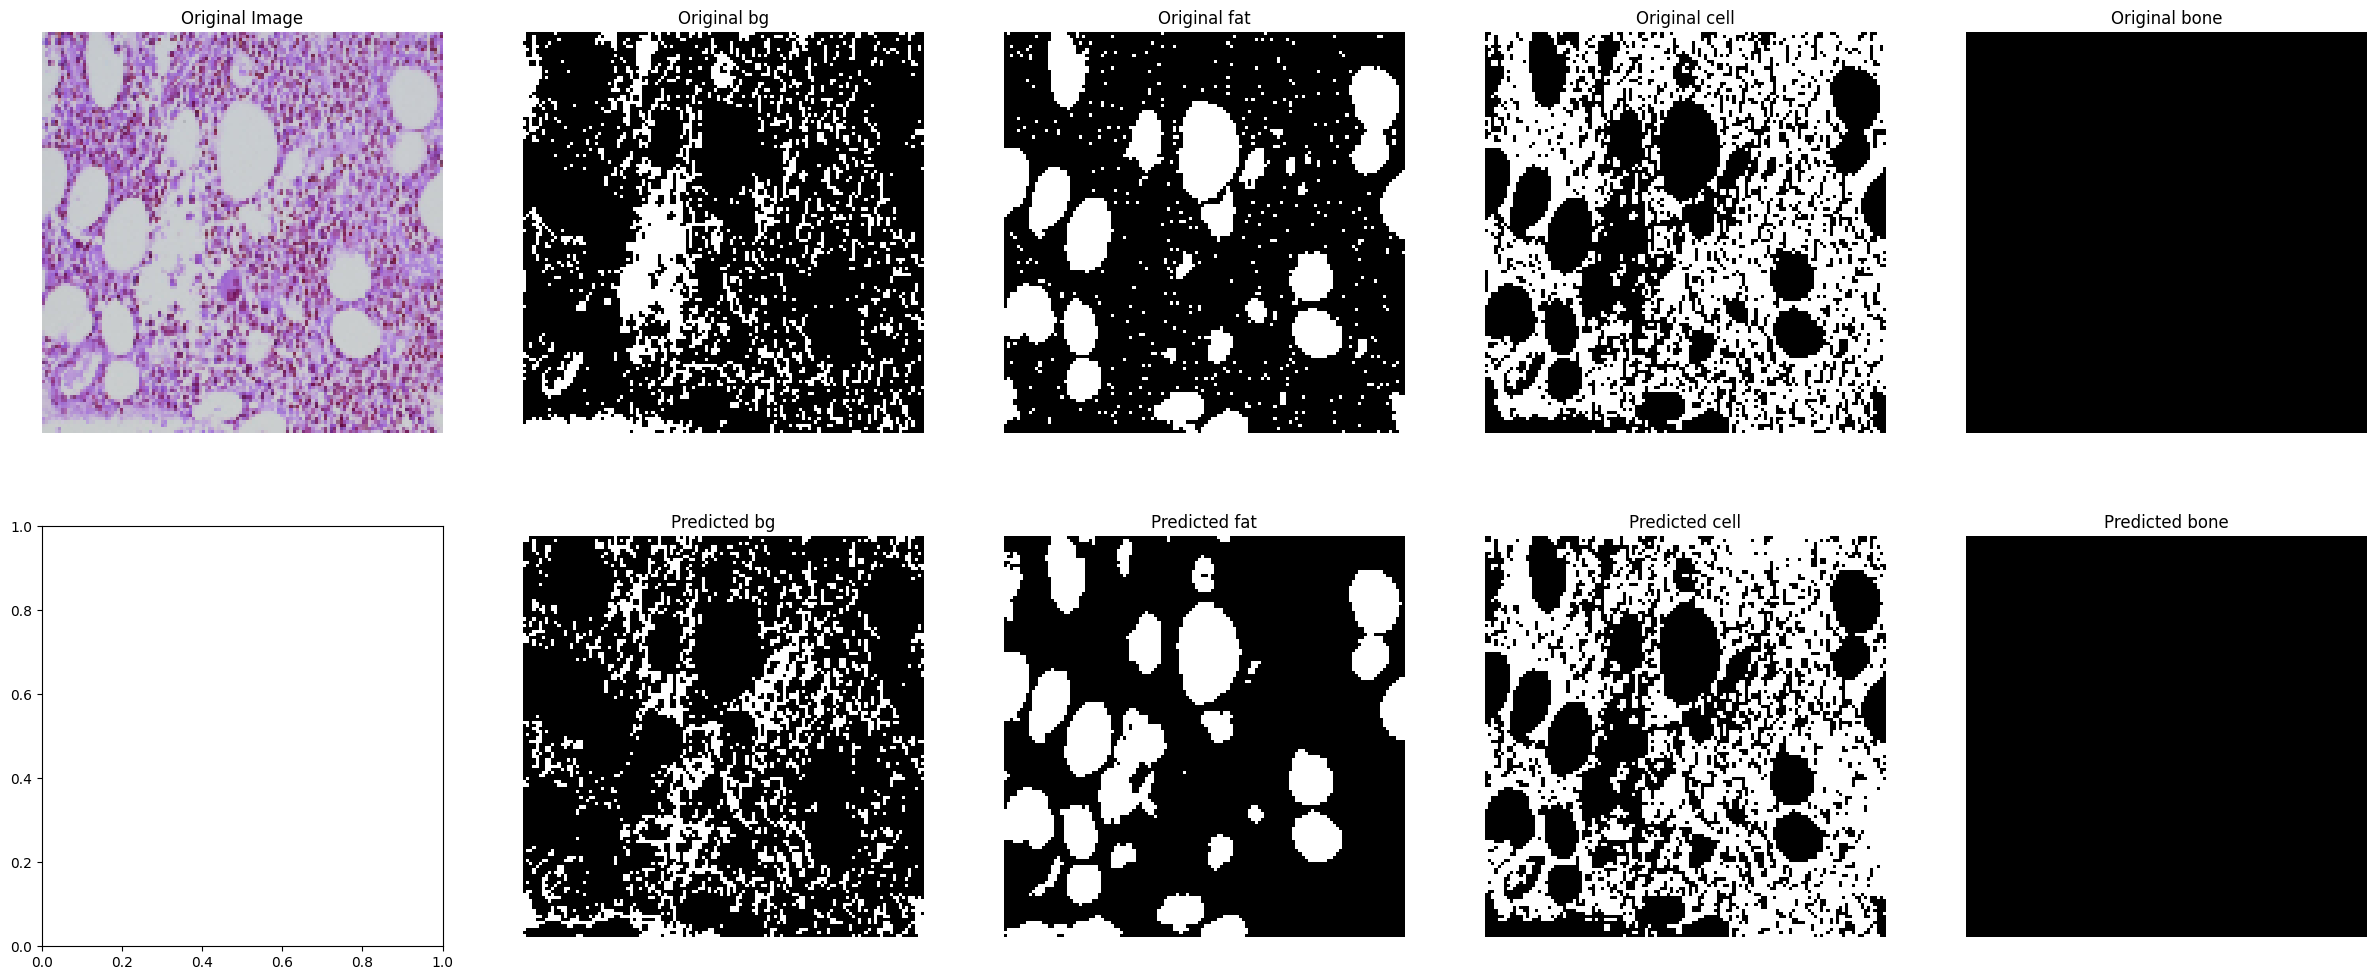

cellulu true=68.529%	cellulu pred='67.447%	Difference=98.918%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


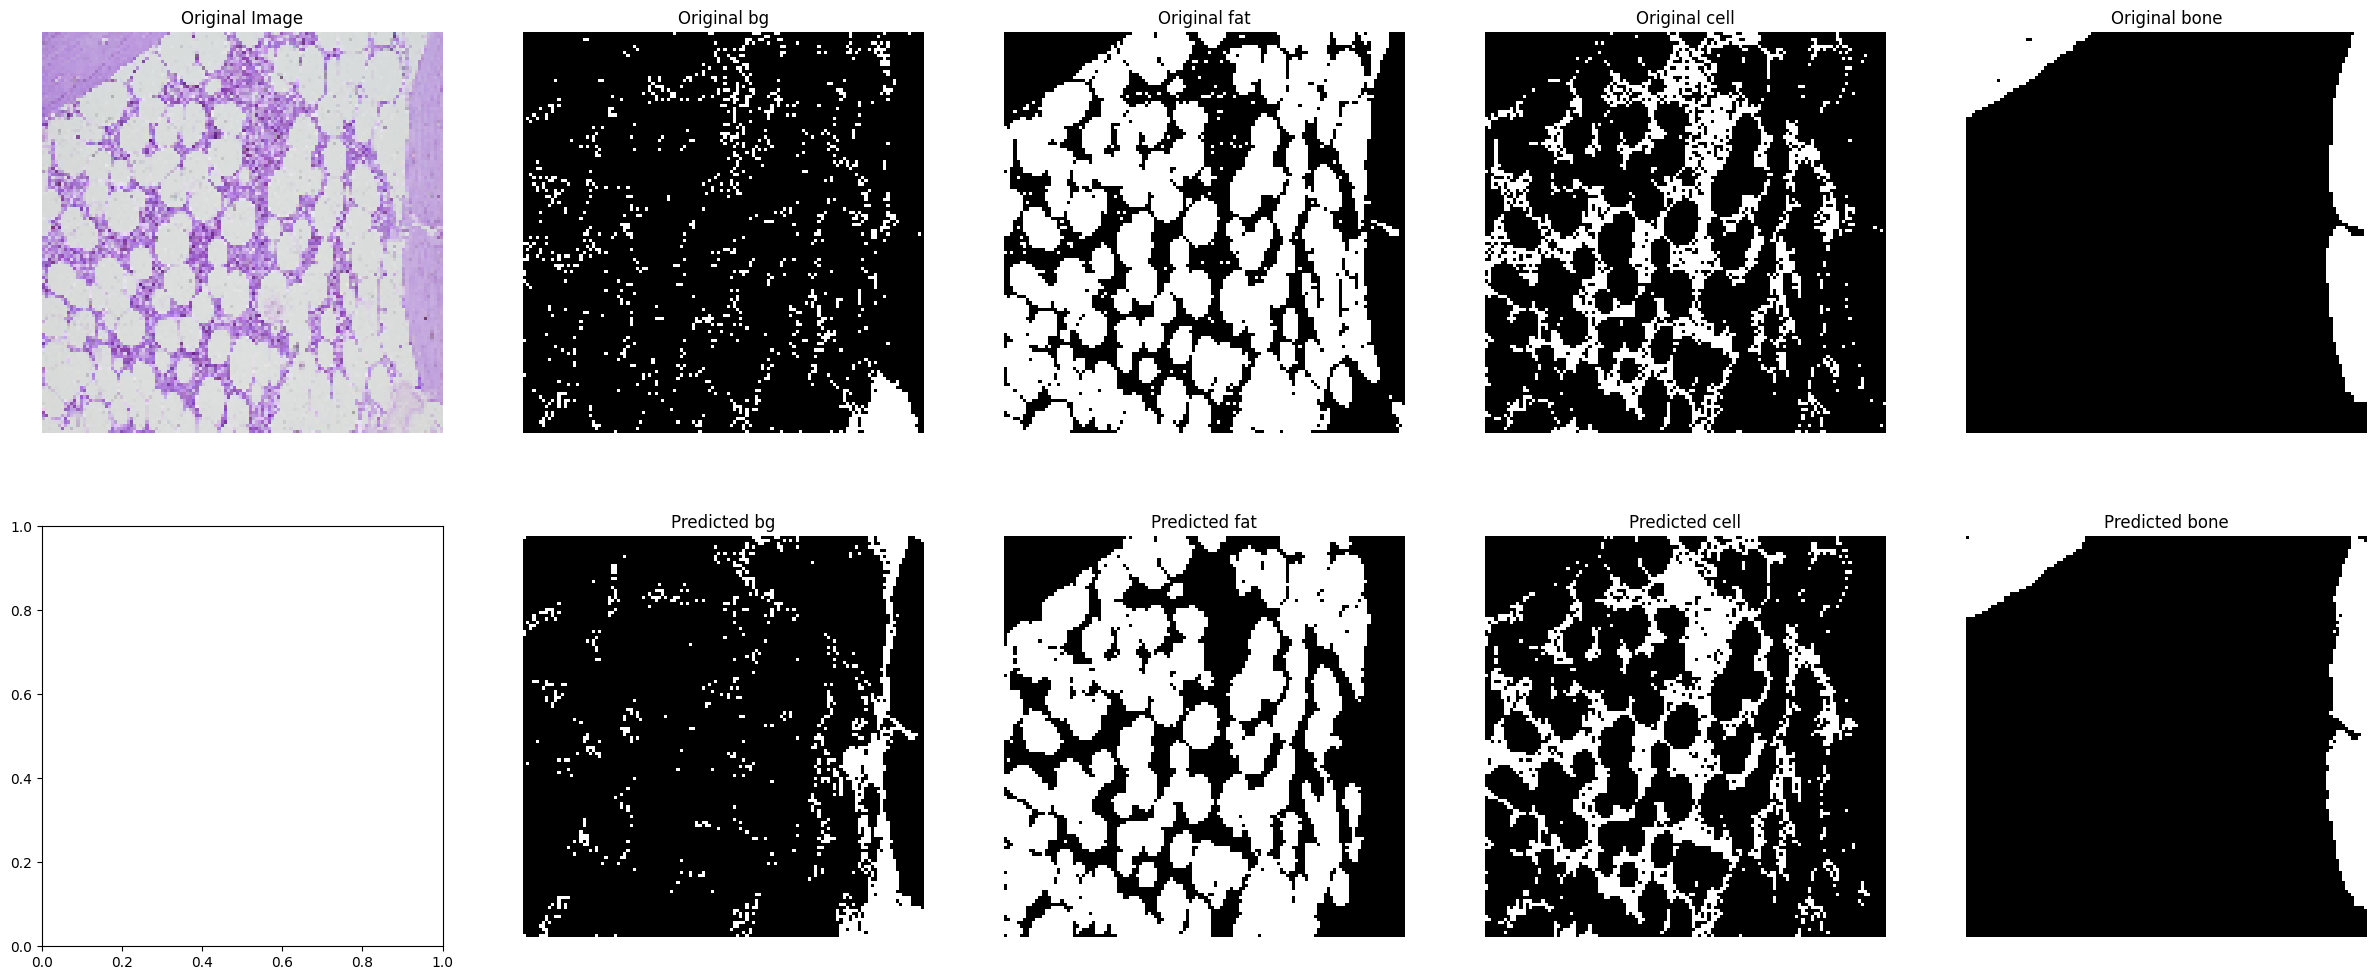

cellulu true=26.741%	cellulu pred='29.592%	Difference=97.149%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


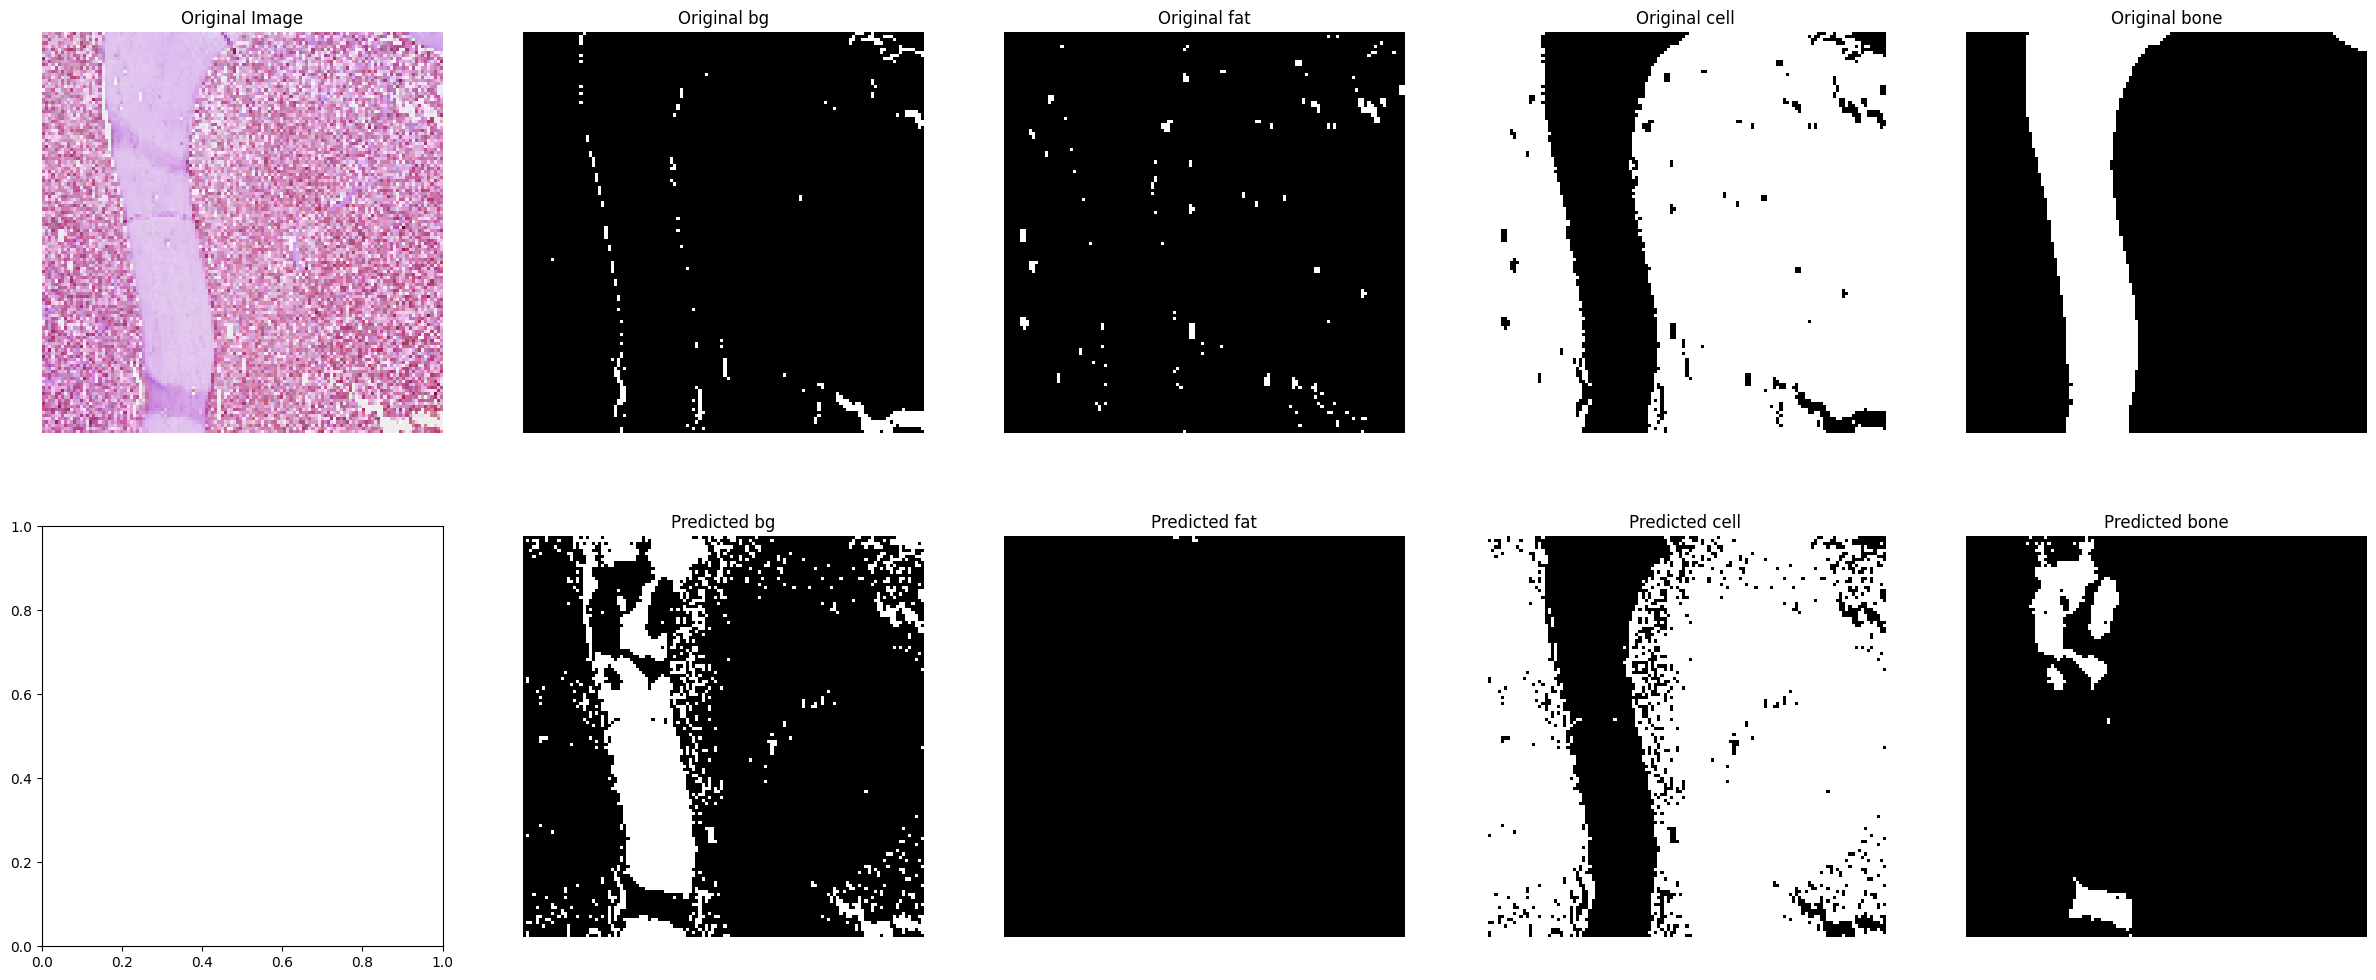

cellulu true=98.216%	cellulu pred='99.959%	Difference=98.257%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


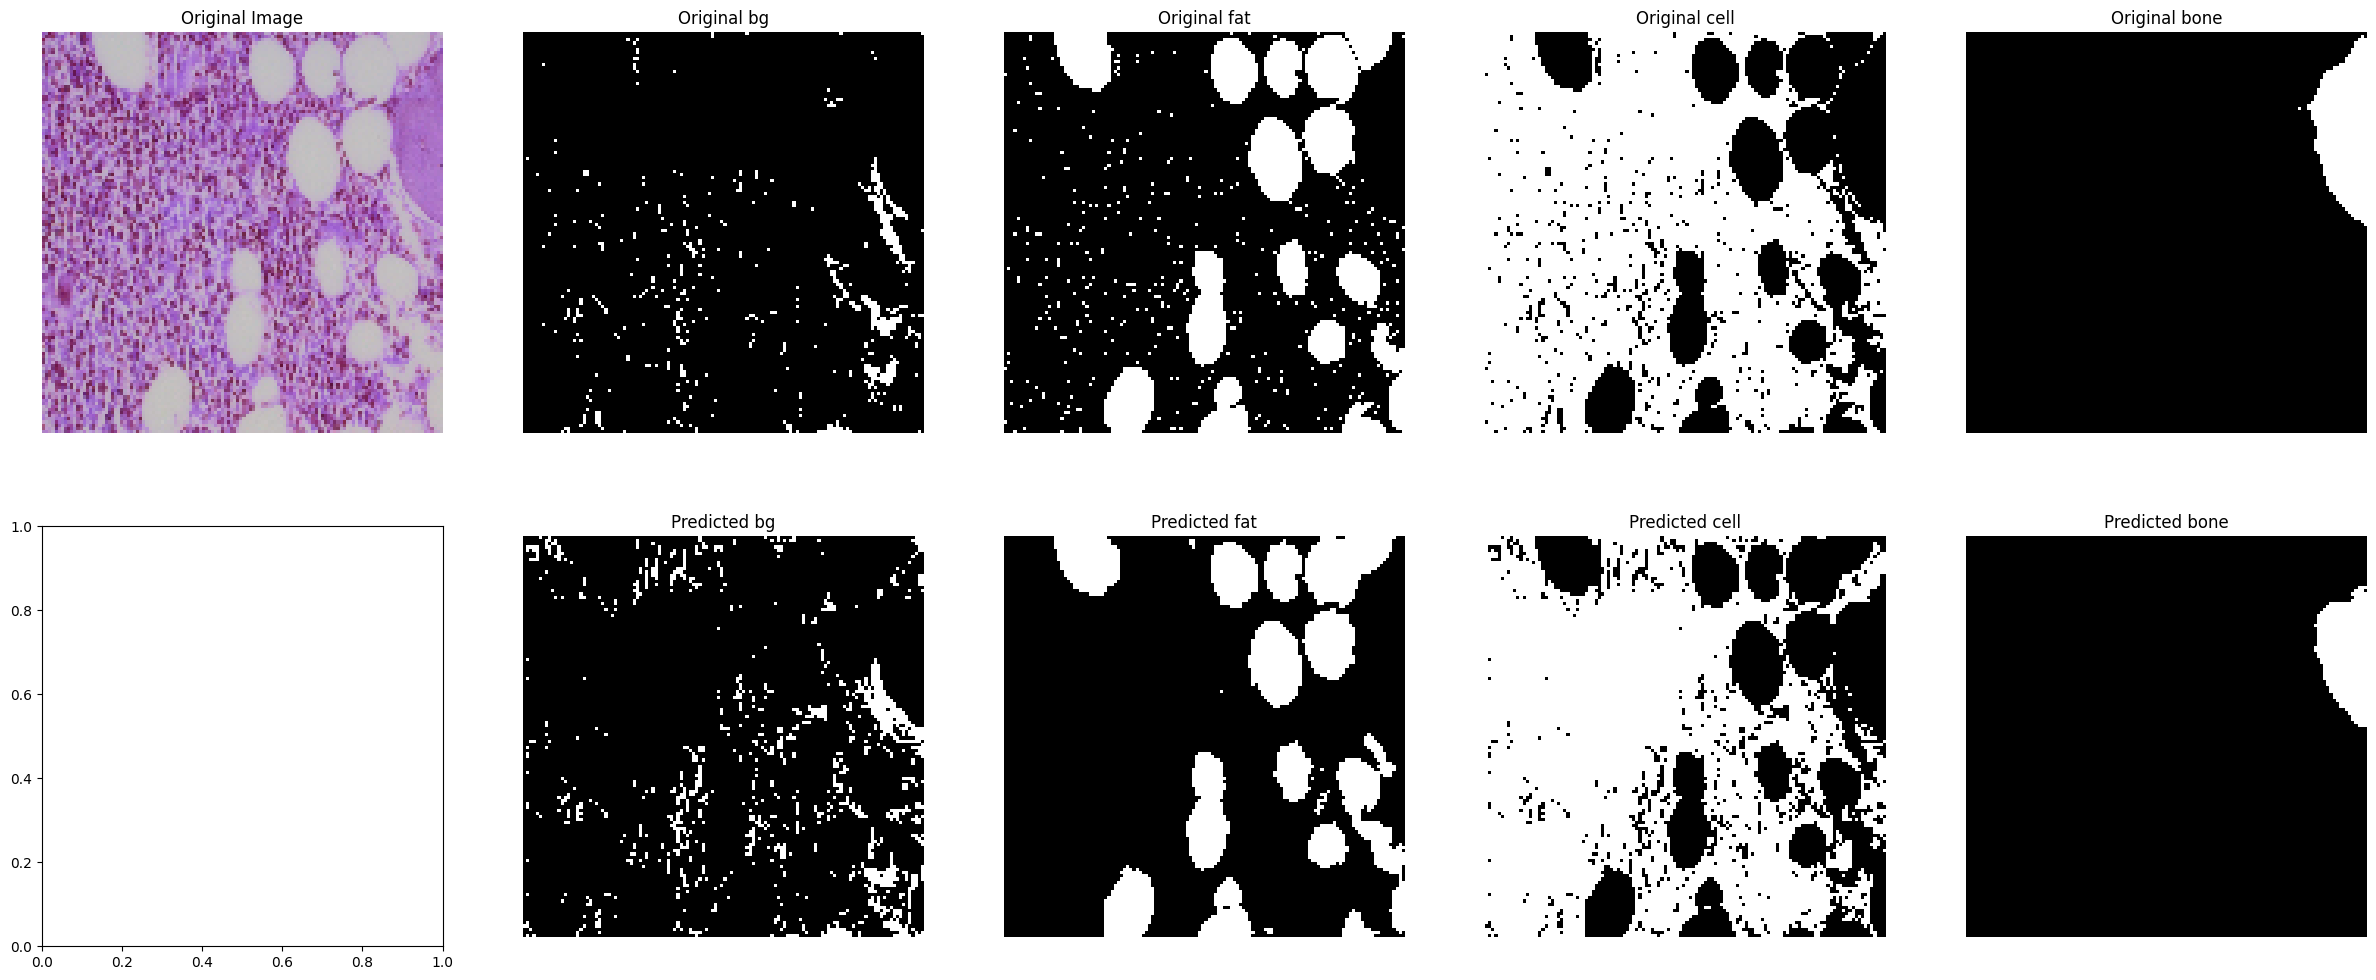

cellulu true=75.837%	cellulu pred='75.752%	Difference=99.915%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


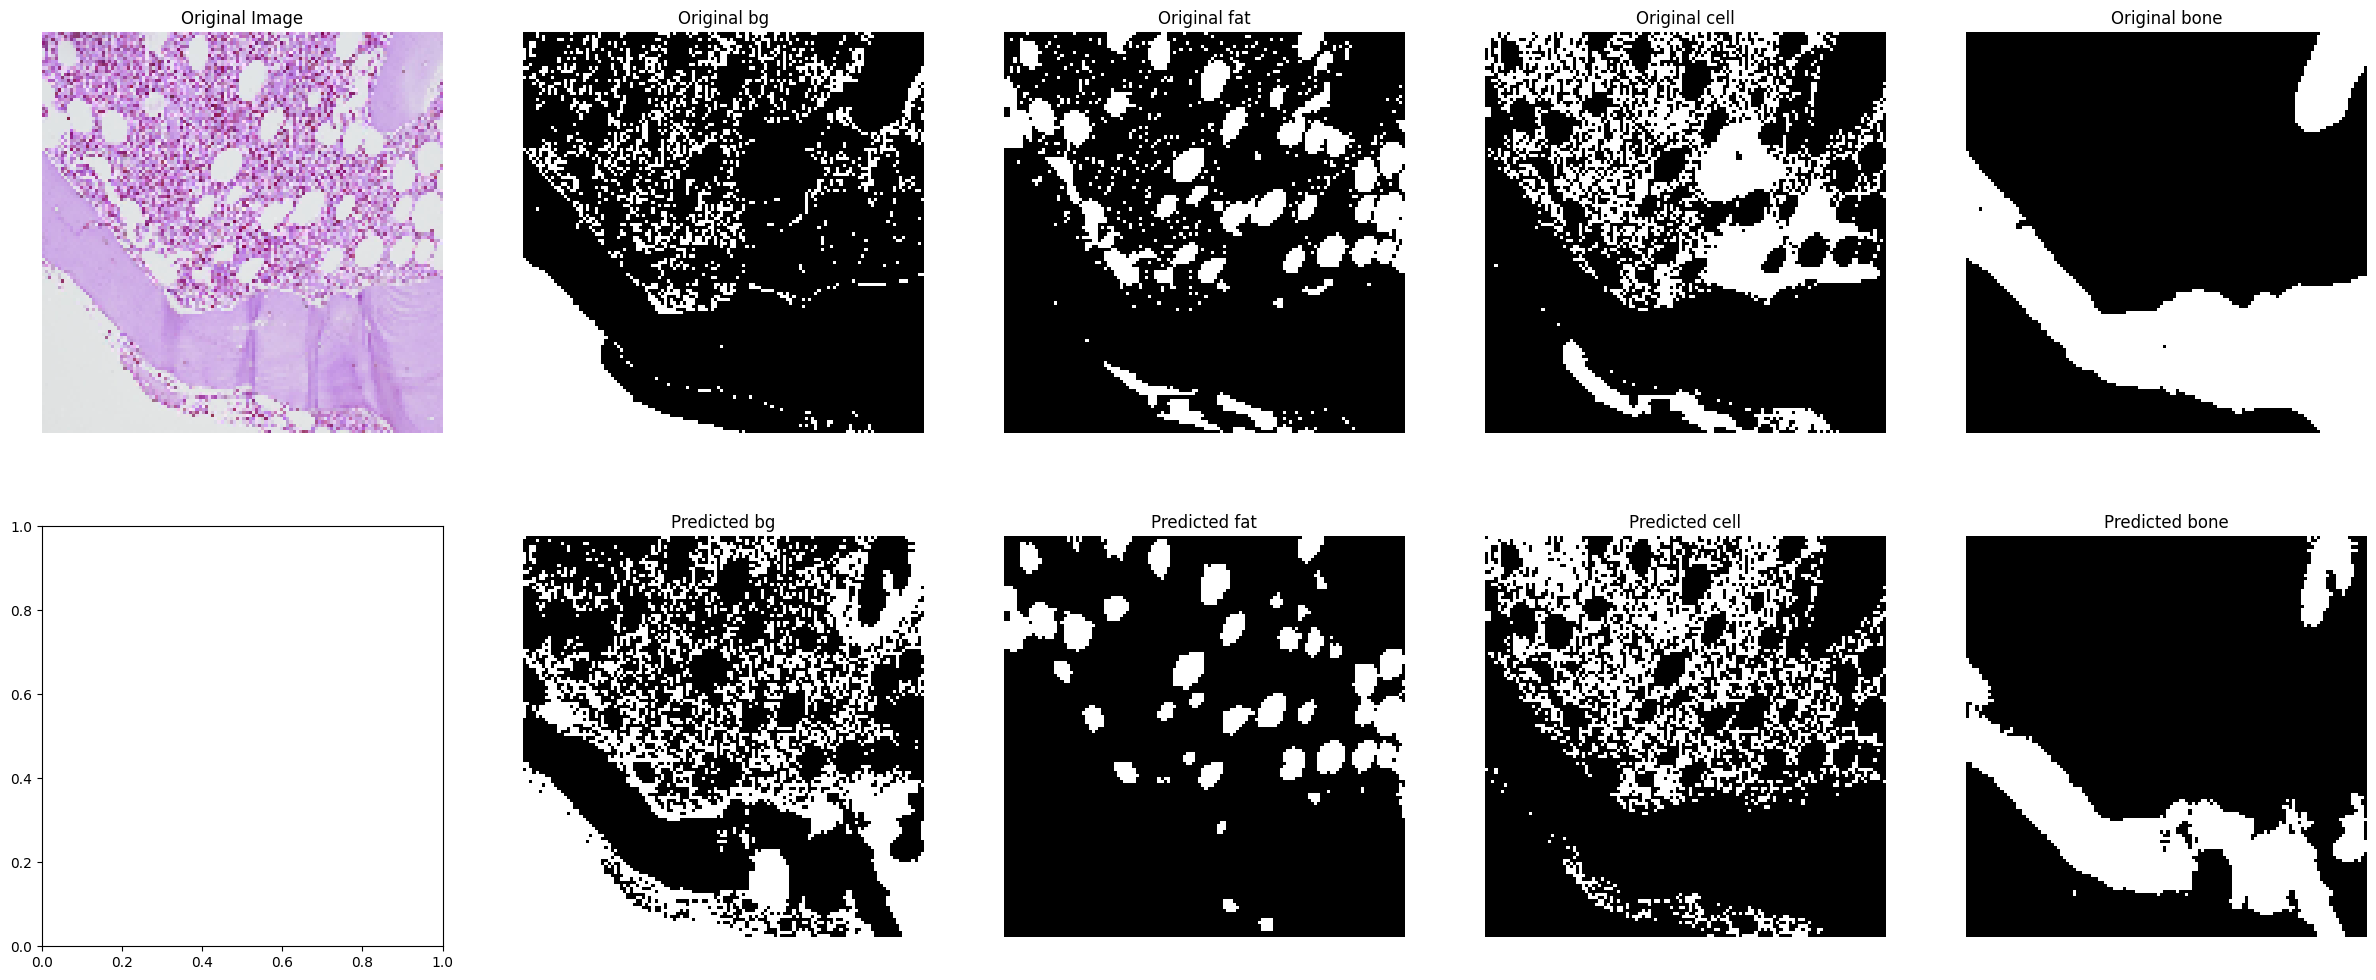

cellulu true=62.076%	cellulu pred='68.685%	Difference=93.391%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


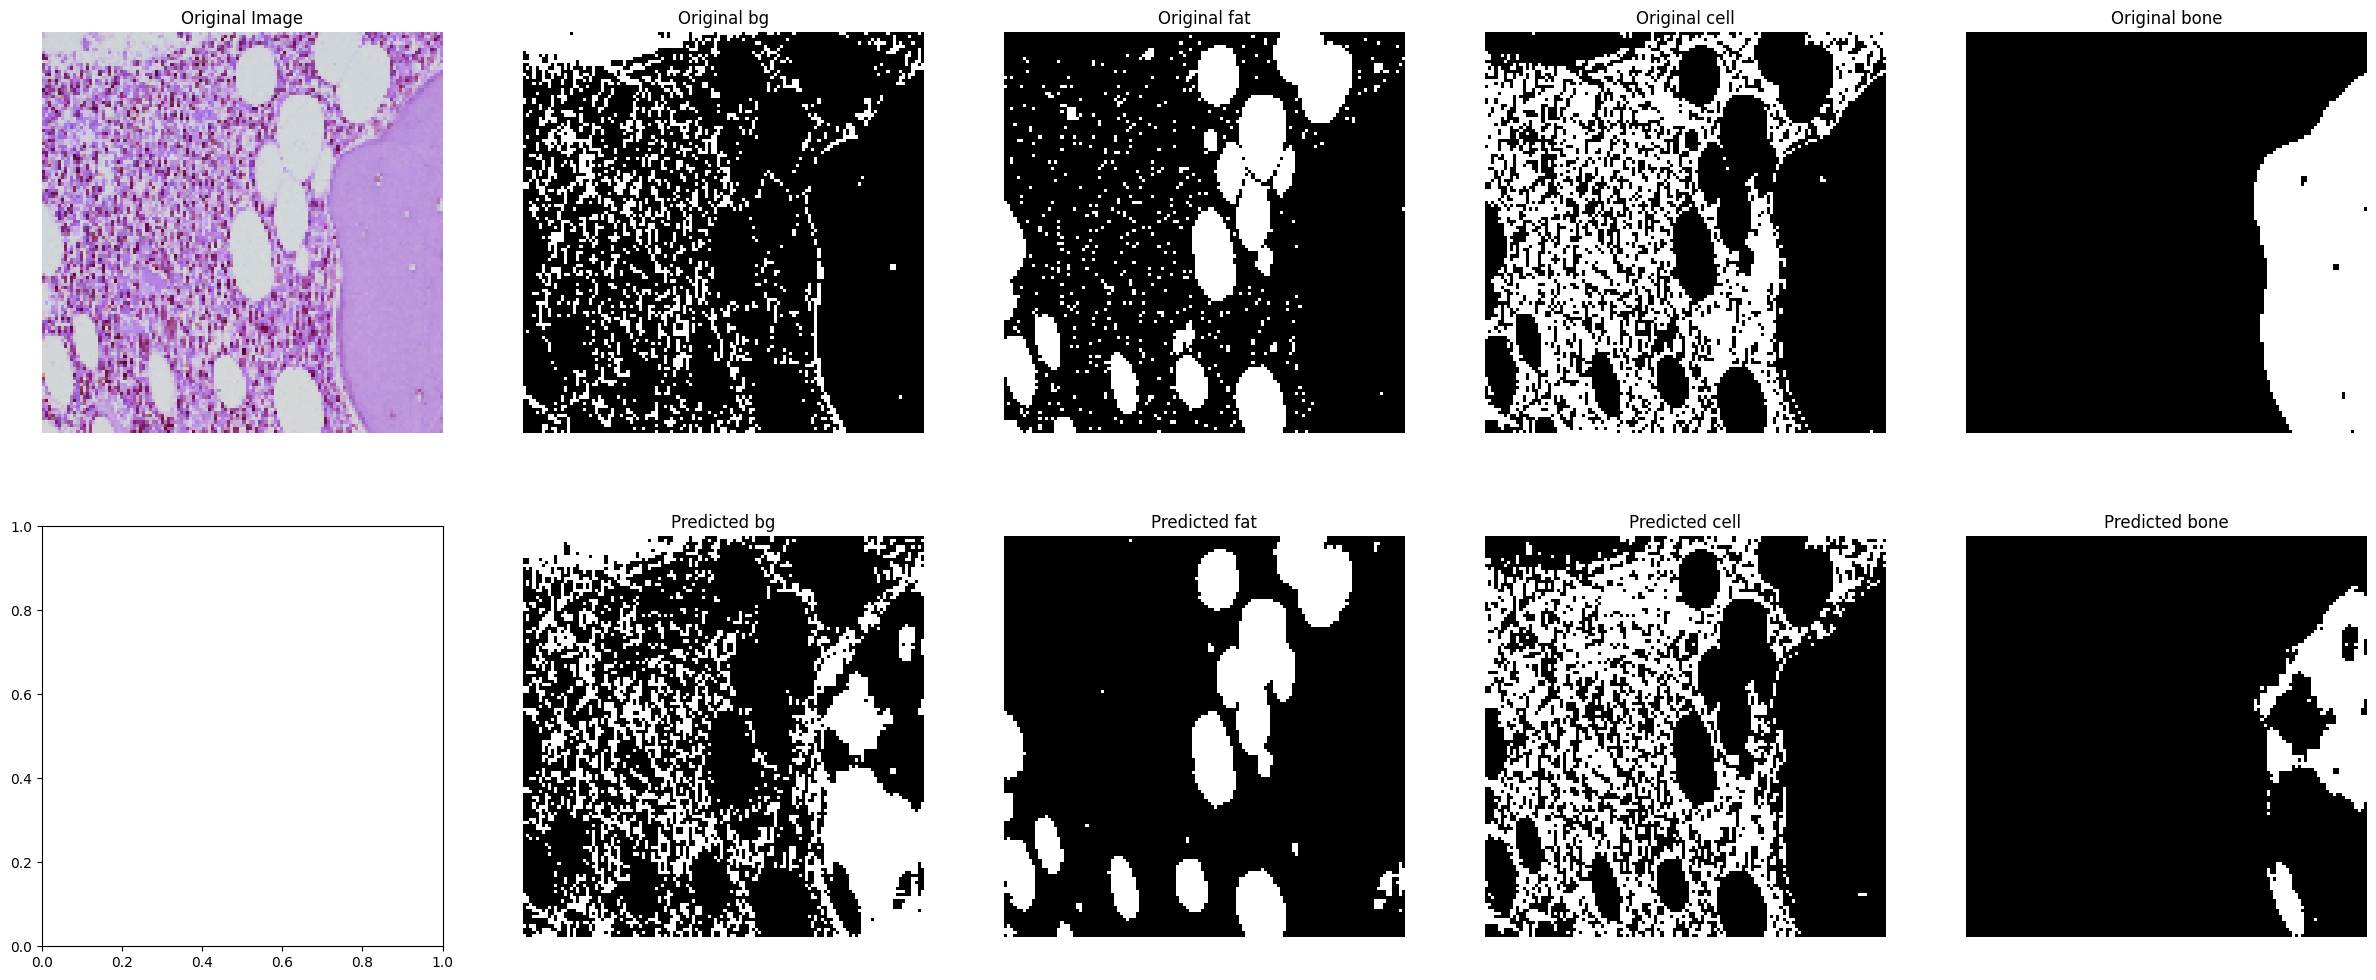

cellulu true=65.742%	cellulu pred='68.192%	Difference=97.550%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


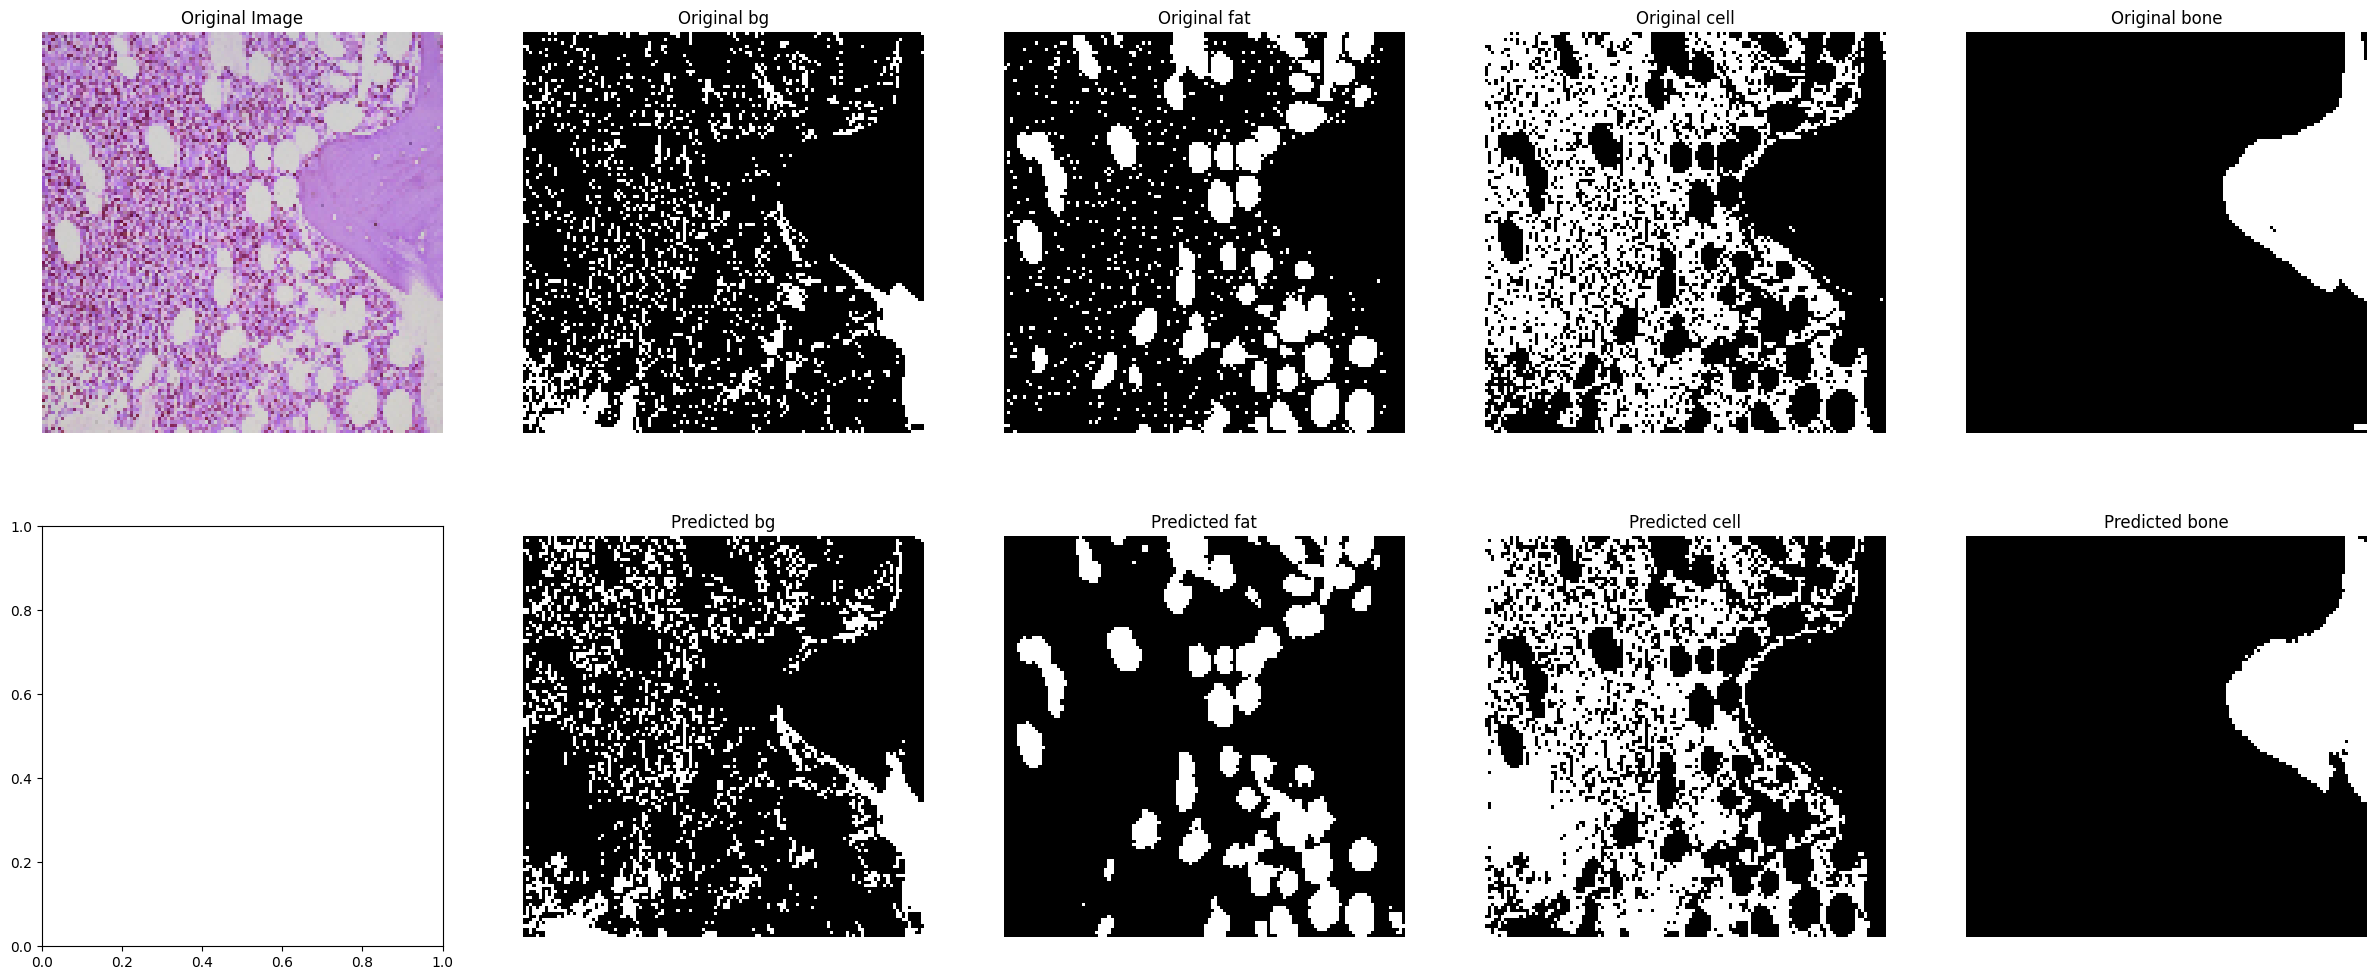

cellulu true=68.415%	cellulu pred='70.642%	Difference=97.773%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


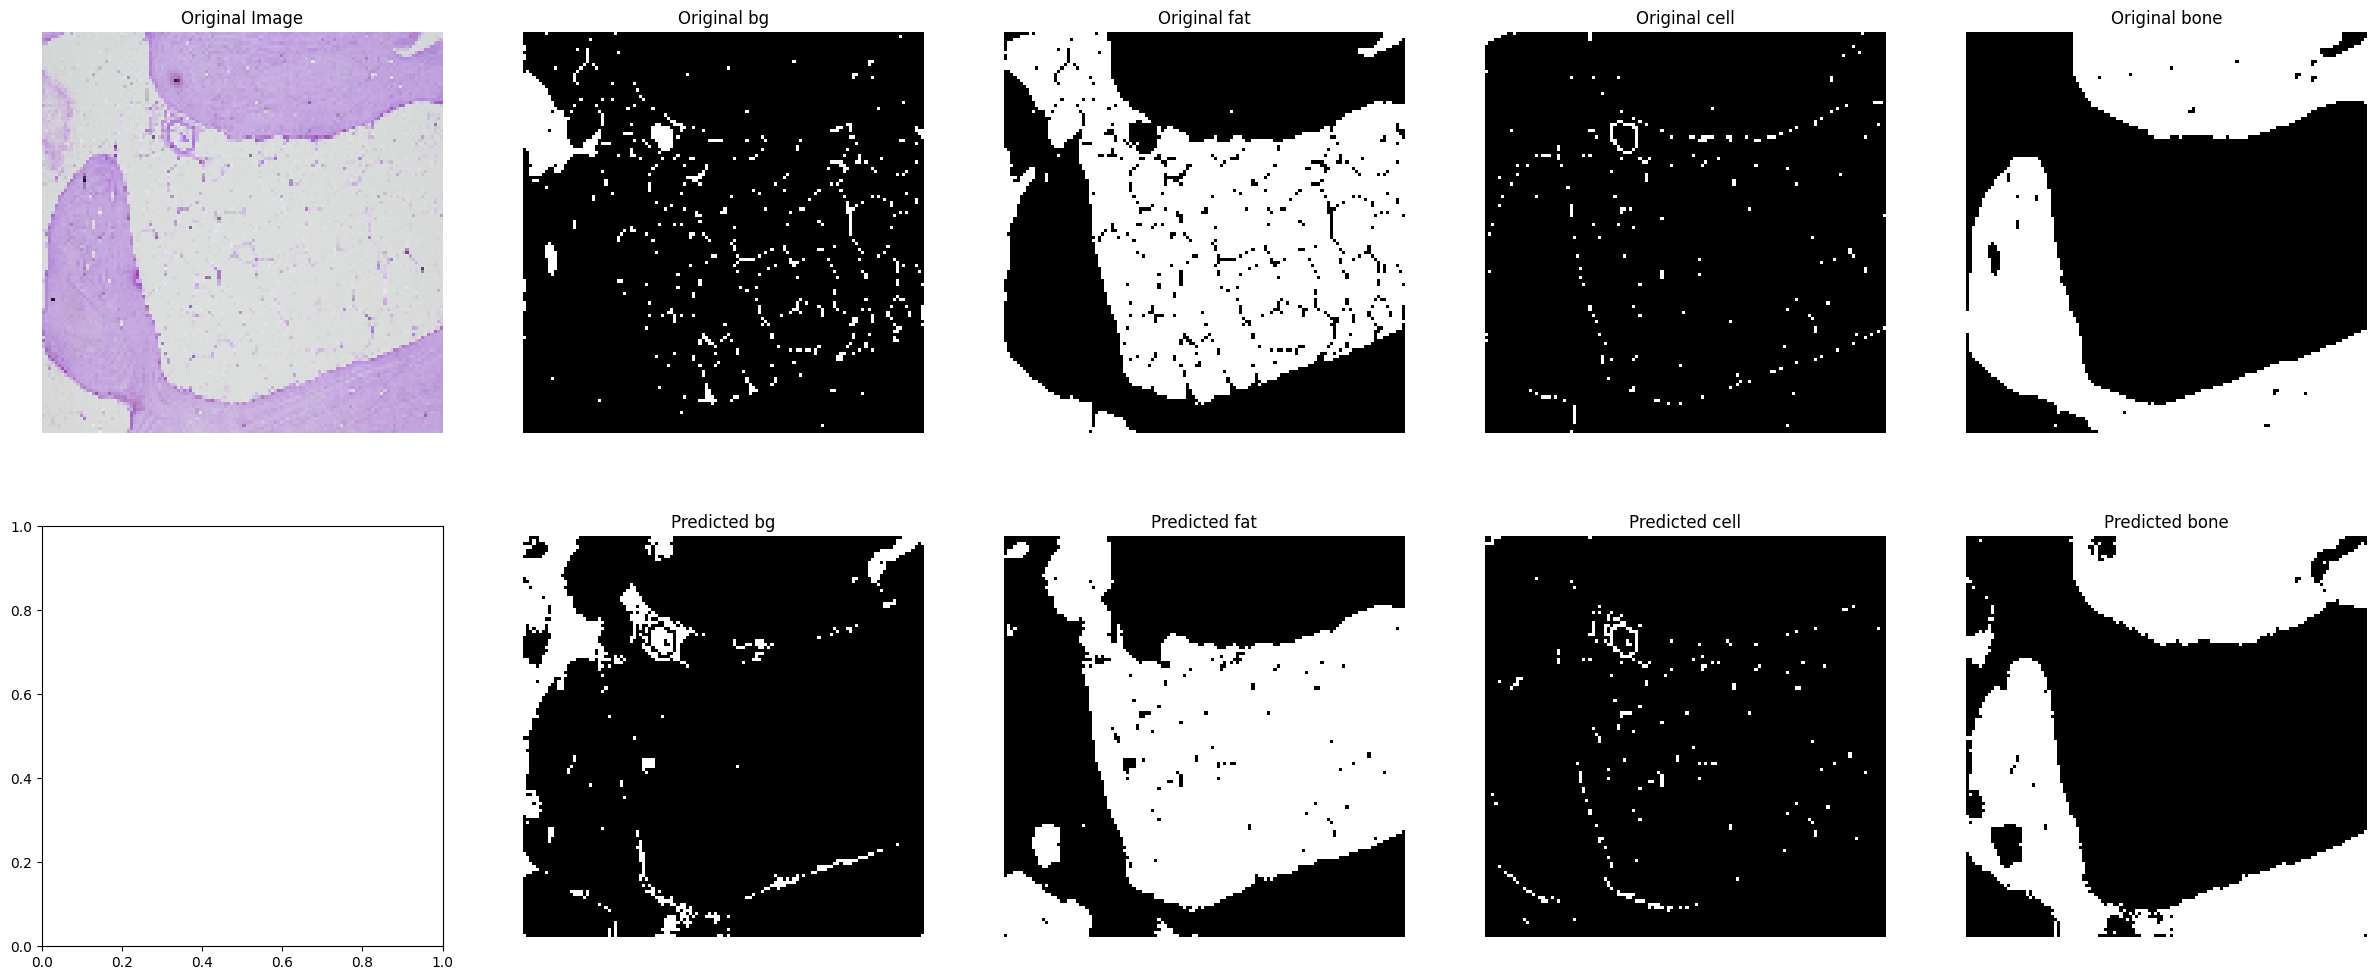

cellulu true=2.797%	cellulu pred='2.890%	Difference=99.907%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


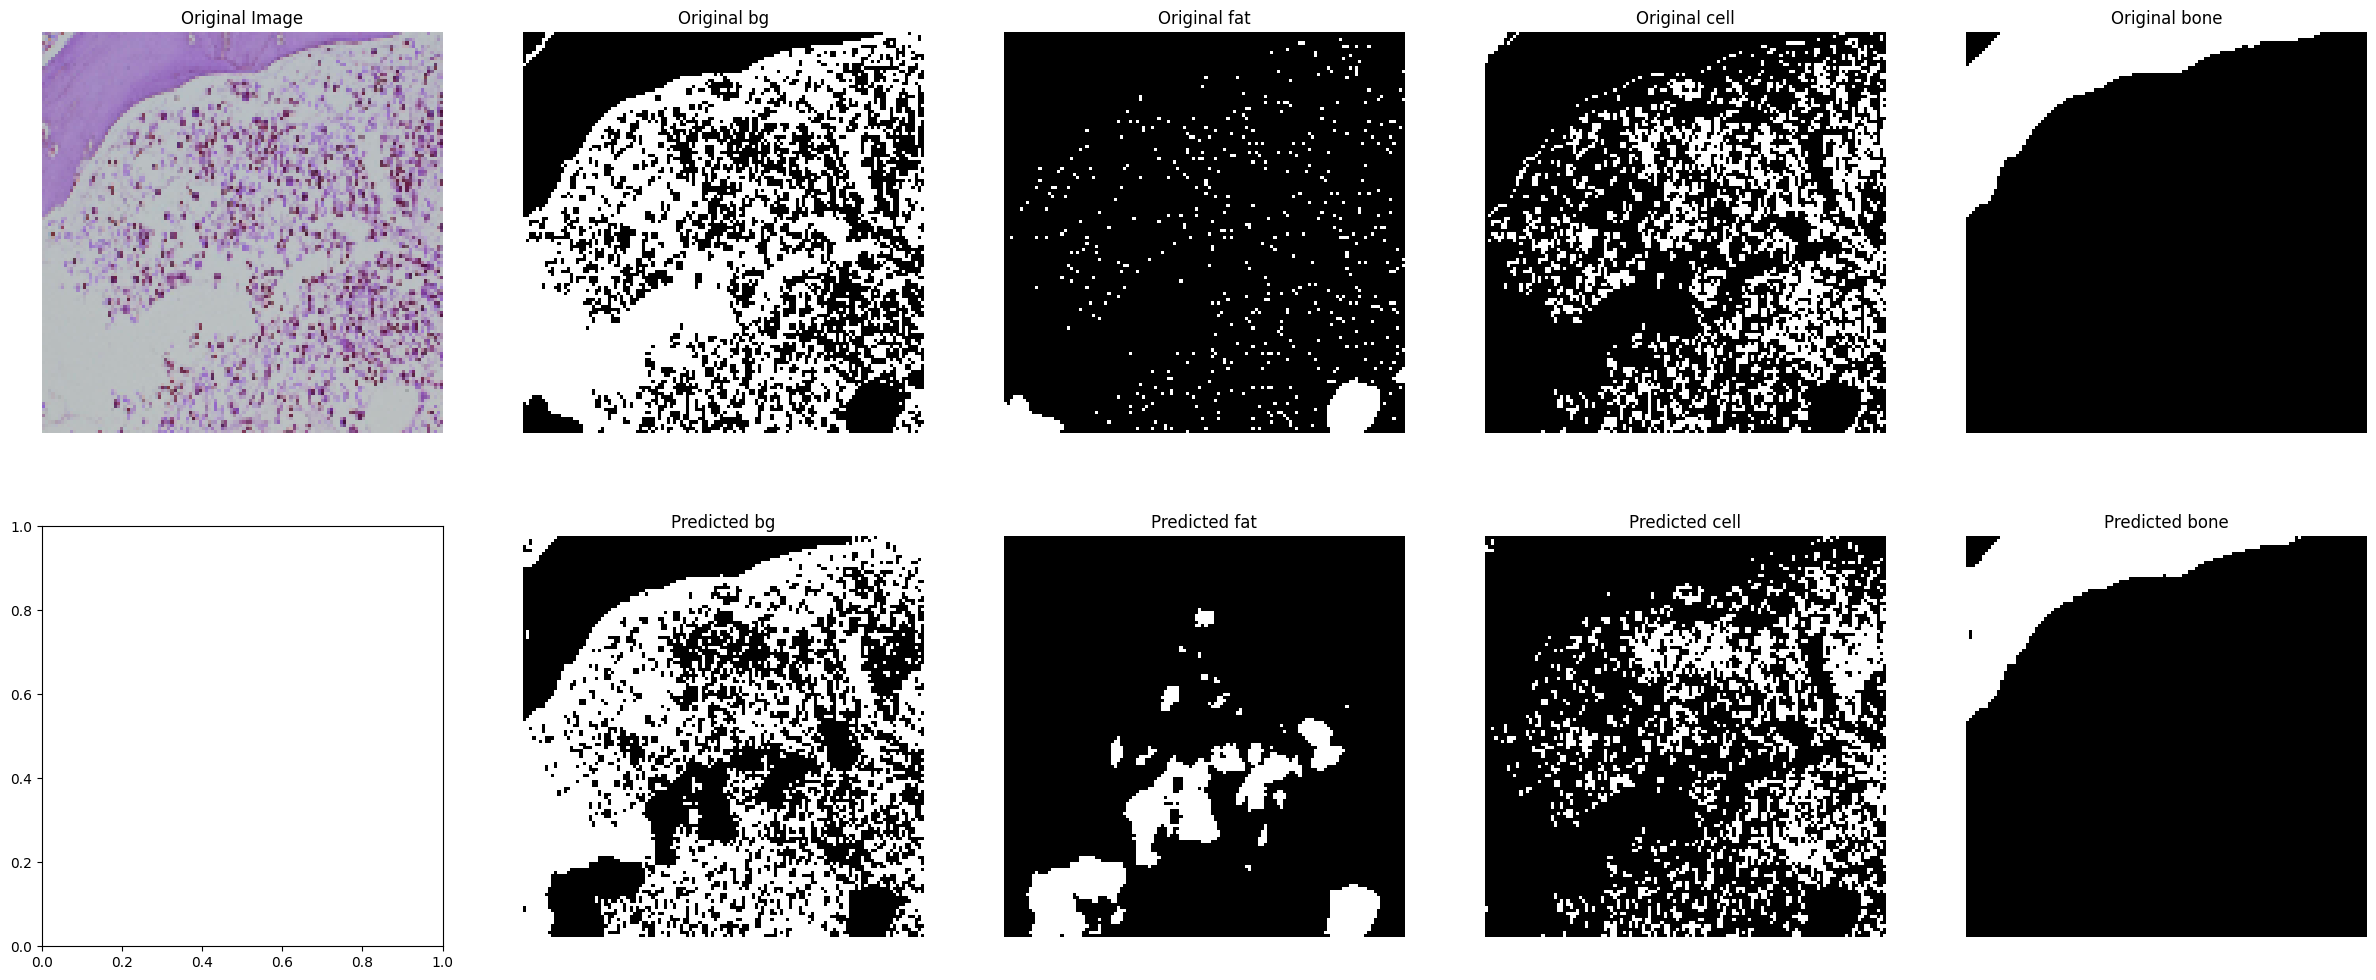

cellulu true=83.628%	cellulu pred='66.992%	Difference=83.364%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


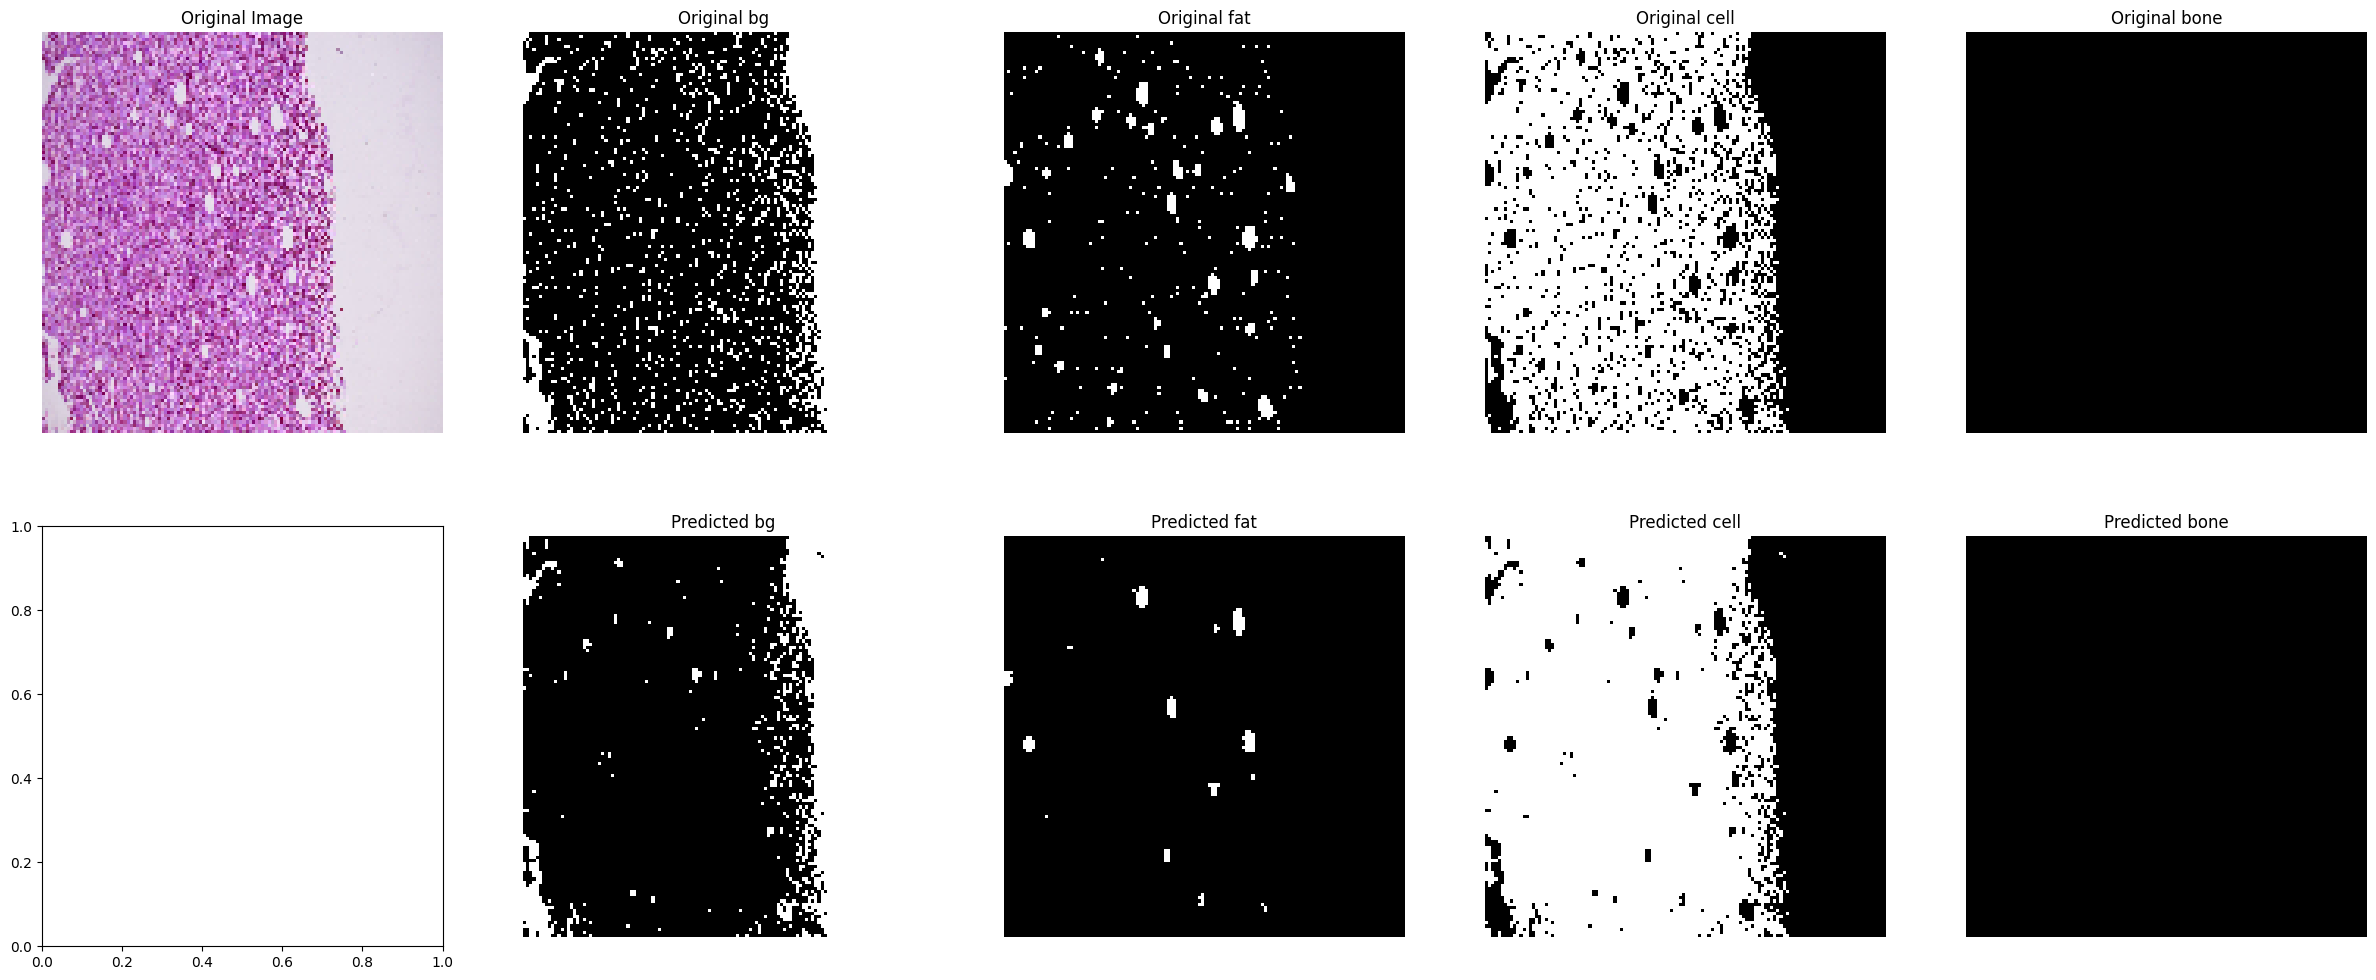

cellulu true=94.033%	cellulu pred='98.561%	Difference=95.472%


2024-05-18 17:51:30.020691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
# for i in range(15):
net_cellulu=0
totalMasks=15

for image, mask in test_dataset.take(15):
        sample_image, sample_mask = image, mask
        net_cellulu+=show_predictions(sample_image, sample_mask)

In [41]:
test_steps = len(test_x)//batch
if len(test_x) % batch != 0: 
    test_steps += 1

result = model.evaluate(test_dataset, steps=test_steps)
dict(zip(model.metrics_names, result))
print(f"Testing Cellularity Accuracy={(net_cellulu/totalMasks):.3f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step - dice_coef: 0.8904 - loss: 0.1976 - mean_iou: 0.8024
Testing Cellularity Accuracy=96.509%


In [42]:
model.save('model_saves/mobilenet_128.h5')  # Saves in the older HDF5 format
model.save('model_saves/mobilenet_128.keras')  # Recommended format (uses ZIP archive)